# KUR1502: MaxQuant (MQ) versus PAW

## Phil Wilmarth, OHSU PSR Core, February 2018

## Load libraries and the dataset:
The data are mouse bone marrow cell cultures from this publication:
> Huan, J., Hornick, N.I., Goloviznina, N.A., Kamimae-Lanning, A.N., David, L.L., Wilmarth, P.A., Mori, T., Chevillet, J.R., Narla, A., Roberts Jr, C.T. and Loriaux, M.M., 2015. Coordinate regulation of residual bone marrow function by paracrine trafficking of AML exosomes. Leukemia, 29(12), p.2285.

The "media" samples are controls (one of the 4 did not label) and there are leukemia exosome-dosed cells (4 "exosome" samples). 10-plex TMT was used on a Thermo Fusion using the SPS MS3 method. The PAW pipeline is our in-house processing using the Comet search engine:
>Eng, J.K., Jahan, T.A. and Hoopmann, M.R., 2013. Comet: an open‐source MS/MS sequence database search tool. Proteomics, 13(1), pp.22-24.

The pipeline converts the RAW files into text files using MSConvert from the Proteowizard toolkit:
>Chambers, M.C., Maclean, B., Burke, R., Amodei, D., Ruderman, D.L., Neumann, S., Gatto, L., Fischer, B., Pratt, B., Egertson, J. and Hoff, K., 2012. A cross-platform toolkit for mass spectrometry and proteomics. Nature biotechnology, 30(10), p.918

Data from the MS2 scans are extracted for the Comet searches and the reporter peak heights are extracted from the MS3 scans. The pipeline uses the target/decoy method to make score histograms and determine score filtering thresholds. Accurate mass is used to create conditional score histograms where target/decoy delta mass histograms are used to set the accurate mass windows. Basic parsimony principles are used for protein inference and 2 peptides per protein were required. An additional protein grouping step was used to combine nearly identical peptide sets (often these are housekeeping genes). The pipeline is described here:
> Wilmarth, P.A., Riviere, M.A. and David, L.L., 2009. Techniques for accurate protein identification in shotgun proteomic studies of human, mouse, bovine, and chicken lenses. Journal of ocular biology, diseases, and informatics, 2(4), pp.223-234.

MaxQuant was also used (version 1.5.7.4) with mostly default values. The reporter ion mass tolerance was changed from 0.01 to 0.003. The proteinGroups file was used to prepare the input for R.
> Cox, J. and Mann, M., 2008. MaxQuant enables high peptide identification rates, individualized ppb-range mass accuracies and proteome-wide protein quantification. Nature biotechnology, 26(12), p.1367.

Data from both pipelines were extracted from the results files with Excel. An accessions column and the 7 columns of TMT reporter ions were retained. Any decoys or contaminants were removed. Proteins were allowed a maximum of one missing data point in either media or exosome samples. Nominal values were used to replace any zero data values (50 for PAW and 5 for MQ).


In [93]:
# load libraries
library(tidyverse) 
library(limma) 
library(edgeR) 

#read the data files (saved as CSV exports from XLSX files)
data_MQ <- read_csv("MQ_prepped_data.csv")
dim(data_MQ)
data_PAW <- read_csv("PAW_prepped_data.csv")
dim(data_PAW)

# save the annotation column and remove from frame
anno_MQ <- data_MQ[8]
data_MQ <- data_MQ[1:7]
row.names(data_MQ) <- anno_MQ$Accession
head(data_MQ)
head(row.names(data_MQ))

# same for PAW
anno_PAW <- data_PAW[8]
data_PAW <- data_PAW[1:7]
row.names(data_PAW) <- anno_PAW$Accession
head(data_PAW)
head(row.names(data_PAW))

Parsed with column specification:
cols(
  Media_2.1 = col_double(),
  Media_2.2 = col_double(),
  Media_3.2 = col_double(),
  Exo_2.1 = col_double(),
  Exo_2.2 = col_double(),
  Exo_3.1 = col_double(),
  Exo_3.2 = col_double(),
  Accession = col_character()
)


[1] 4864    8

Parsed with column specification:
cols(
  Media_2.1 = col_double(),
  Media_2.2 = col_double(),
  Media_3.2 = col_double(),
  Exo_2.1 = col_double(),
  Exo_2.2 = col_double(),
  Exo_3.1 = col_double(),
  Exo_3.2 = col_double(),
  Accession = col_character()
)


[1] 4880    8

Warning message:
“Setting row names on a tibble is deprecated.”

Media_2.1 Media_2.2 Media_3.2 Exo_2.1   Exo_2.2   Exo_3.1  Exo_3.2 
1  2192.7    2451.20   2618.8    5948.000  5236.200  9566.00 11218.00
2 16166.0   19475.00  20181.0   37464.000 30435.000 66189.00 77581.00
3  4963.1    6536.90   4125.3    2281.300  1715.200  2335.30  3045.40
4   225.3     710.05    479.9      89.244    93.066   354.58   102.32
5  8682.4   11858.00   9156.5   14046.000 12271.000 11821.00 13981.00
6     0.0       0.00      0.0    2137.000  1803.100   774.70   833.72

[1] "A0A0B4J1G0" "A1L314"     "A2A432"     "A2A4P0"     "A2A5R2"    
[6] "Q80Y50"

Warning message:
“Setting row names on a tibble is deprecated.”

Media_2.1  Media_2.2 Media_3.2  Exo_2.1    Exo_2.2    Exo_3.1    Exo_3.2   
1  17176.667  18373.79  20207.487  43608.931  38753.788  69712.217  84569.287
2 222416.037 278006.13 258481.586 413029.624 342793.142 690879.498 790929.176
3  42303.342  59989.47  47089.587  22846.630  17203.657  28344.861  28281.443
4  14561.088  19857.98  18019.557  11564.882   8860.283  19871.955  18646.281
5  97031.879 125523.49  93152.521 128637.734 111808.755 116842.868 134418.838
6   6536.312   7659.45   6598.129   4603.276   3043.767   4302.922   5851.341

[1] "A0A0B4J1G0" "A1L314"     "A2A432"     "A2A4P0"     "A2A5R2"    
[6] "A2A6Q5"

## Data from both pipelines need some prepping before loading
The data cleanup was similar for both results files. MQ allows single peptide per protein IDs. PAW requires 2 peptides per protein. MQ search parameters were the defaults. PAW uses a wider tolerance Comet search (1.25 Da), then makes score distributions histograms conditioned on accurate masses. PSMs with an accurate mass (set by a delta mass histogram) are filtered to an FDR of 1% in PAW based on target/decoy counts. For this dataset, both pipelines had similar numbers of identified proteins.

Supporting files are organized to help understand this data cleanup process:
* **MQ_data_prep_steps.txt** has step-by-step details
* **proteinGroups.txt** is the starting MQ file
* **KUR1502_proteinGroups_int1.xlsx** is an intermediate save (referenced in steps)
* **KUR1502_proteinGroups_int2.xlsx** is the version at the end of the prep steps

## Need to do something with zeros in MQ data (PAW is OK)
We will replace any zeros in the MQ data table with the value of 5 (we used 50 in PAW).

## What do the raw (un-normalized) data distributions look like?
We will use box plots, a common way to summarize distributions, and distribution density plots to visualize the Log base 2 of the intensities. The 3 media samples are in one color and the 4 exosome-dosed samples are in another color. We will also look at density distributions. MQ data first, then PAW data.

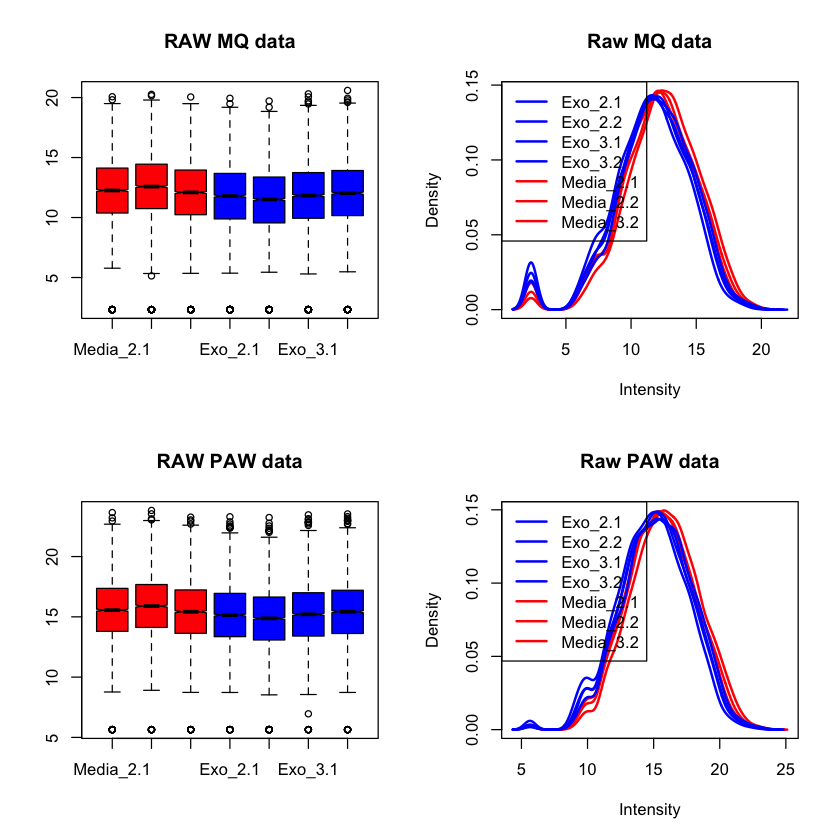

In [94]:
# take care of the zeros in MQ frame
data_MQ[data_MQ <= 1] <- 5

# do this in a 2x2 plot
par(mfrow = c(2, 2))

# let's see what the starting MQ data look like
boxplot(log2(data_MQ), col = c(rep("red", 3), rep("blue", 4)), 
        notch = TRUE, main = "RAW MQ data")

# NOTE: density distributions order samples differently than box plots...
plotDensities(log2(data_MQ), col = c(rep("blue", 4), rep("red", 3)), main = "Raw MQ data")

# PAW data
boxplot(log2(data_PAW), col = c(rep("red", 3), rep("blue", 4)), 
        notch = TRUE, main = "RAW PAW data")

plotDensities(log2(data_PAW), col = c(rep("blue", 4), rep("red", 3)), main = "Raw PAW data")
par(mfrow = c(1, 1))

## There are more missing data values in MQ than PAW
The small bump near the origin in both density plots are the zero replacement values.

## Do we need to do some data normalization?
Let's check the total signal in each channel for the 7 samples (below). We have significant differences that we can correct with some basic normalizing. There was supposed to be the same amount of protein labeled in each sample. We should have the total signals in each channel summing to the same value. We can average the numbers below and compute normalization factors to make the sums end up the same.

In [95]:
print("MQ:")
format(round(colSums(data_MQ), digits = 0), big.mark = ",")
print("PAW:")
format(round(colSums(data_PAW), digits = 0), big.mark = ",")

[1] "MQ:"


Media_2.1     Media_2.2     Media_3.2       Exo_2.1       Exo_2.2 
"106,086,271" "129,997,818" " 93,406,695" " 76,529,590" " 62,206,244" 
      Exo_3.1       Exo_3.2 
" 85,277,172" " 96,579,304"

[1] "PAW:"


Media_2.1       Media_2.2       Media_3.2         Exo_2.1         Exo_2.2 
"1,004,259,290" "1,241,766,663" "  894,596,889" "  733,261,436" "  602,872,732" 
        Exo_3.1         Exo_3.2 
"  814,189,831" "  928,530,343"

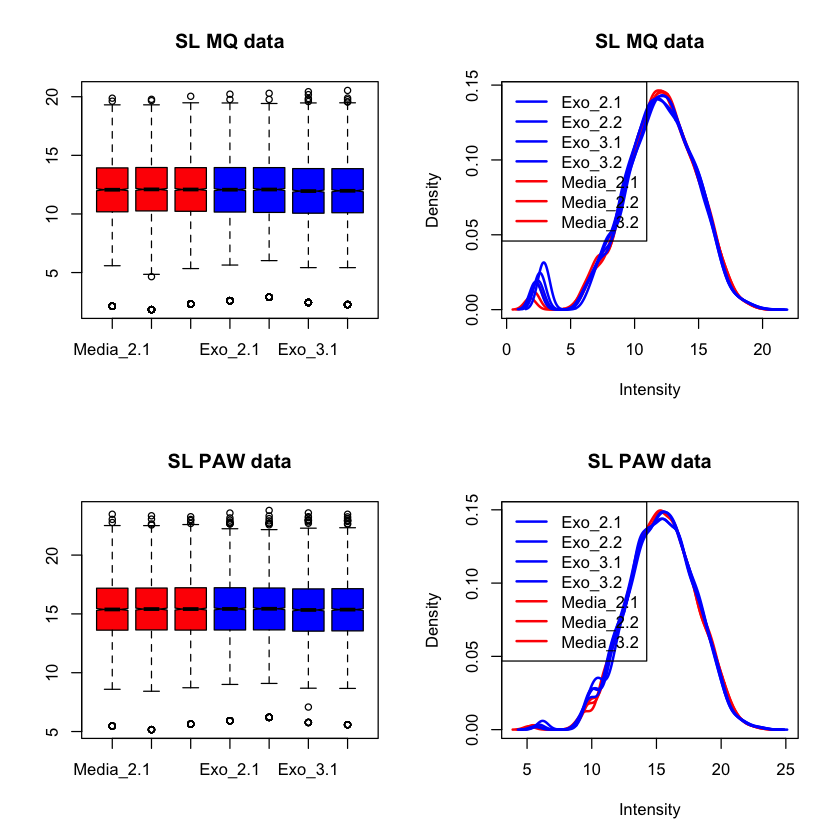

In [96]:
# figure out the global scaling value
target_MQ <- mean(colSums(data_MQ))
target_PAW <- mean(colSums(data_PAW))

# do the sample loading normalization before the IRS normalization
# there is a different correction factor for each column
norm_facs_MQ <- target_MQ / colSums(data_MQ)
data_MQ_sl <- sweep(data_MQ, 2, norm_facs_MQ, FUN = "*")
norm_facs_PAW <- target_PAW / colSums(data_PAW)
data_PAW_sl <- sweep(data_PAW, 2, norm_facs_PAW, FUN = "*")

par(mfrow = c(2, 2))
# see what the SL normalized data look like
boxplot(log2(data_MQ_sl), col = c(rep("red", 3), rep("blue", 4)), 
        notch = TRUE, main = "SL MQ data")

# NOTE: density distributions order samples differently than box plots...
plotDensities(log2(data_MQ_sl), col = c(rep("blue", 4), rep("red", 3)), main = "SL MQ data")

# PAW data
boxplot(log2(data_PAW_sl), col = c(rep("red", 3), rep("blue", 4)), 
        notch = TRUE, main = "SL PAW data")

plotDensities(log2(data_PAW_sl), col = c(rep("blue", 4), rep("red", 3)), main = "SL PAW data")
par(mfrow = c(1, 1))

In [97]:
# check the columnn totals
format(round(colSums(data_MQ_sl), digits = 0), big.mark = ",")
format(round(colSums(data_PAW_sl), digits = 0), big.mark = ",")

Media_2.1    Media_2.2    Media_3.2      Exo_2.1      Exo_2.2      Exo_3.1 
"92,869,013" "92,869,013" "92,869,013" "92,869,013" "92,869,013" "92,869,013" 
     Exo_3.2 
"92,869,013"

Media_2.1     Media_2.2     Media_3.2       Exo_2.1       Exo_2.2 
"888,496,741" "888,496,741" "888,496,741" "888,496,741" "888,496,741" 
      Exo_3.1       Exo_3.2 
"888,496,741" "888,496,741"

## MQ has different scale but looks similar otherwise
MQ might be dividing peak heights by the number of reporter ions (10 here). The very low bump in the density plots are the replacments for zeros (5 in MQ and 50 in PAW).

Sample loading normalization looks sufficient, but we can add trimmed mean of M-values (TMM) normalization from edgeR anyway.

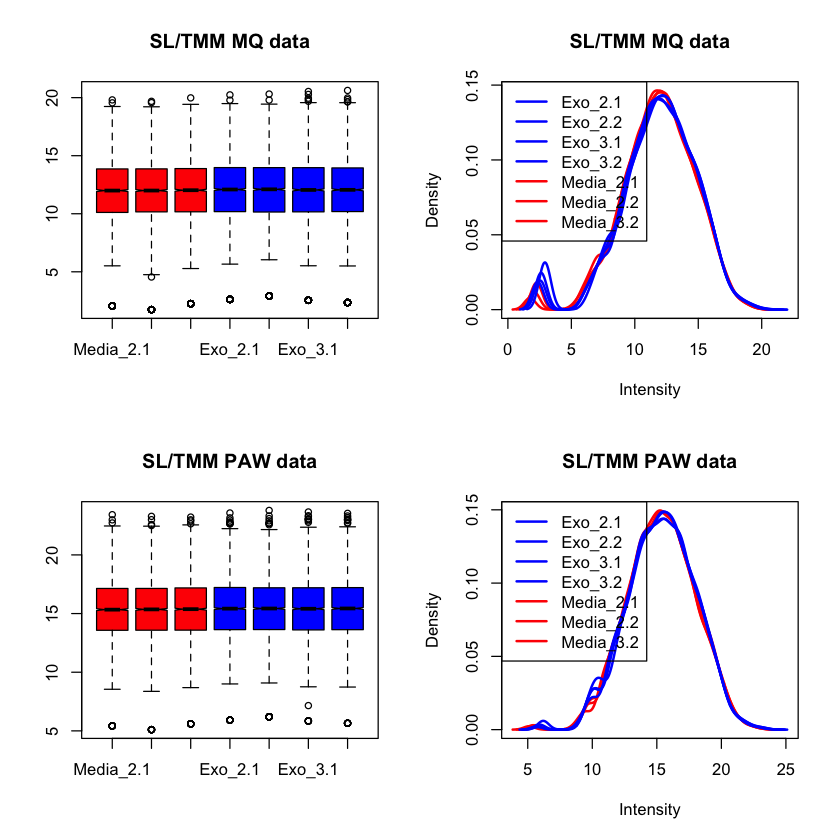

In [98]:
# do TMM on MQ data
MQ_tmm <- calcNormFactors(data_MQ_sl)
data_MQ_tmm <- sweep(data_MQ_sl, 2, MQ_tmm, FUN = "/") # this is data after SL and TMM on original scale

# also on PAW data
PAW_tmm <- calcNormFactors(data_PAW_sl)
data_PAW_tmm <- sweep(data_PAW_sl, 2, PAW_tmm, FUN = "/") # this is data after SL and TMM on original scale

par(mfrow = c(2, 2))
boxplot(log2(data_MQ_tmm), col = c(rep("red", 3), rep("blue", 4)), 
        notch = TRUE, main = "SL/TMM MQ data")
plotDensities(log2(data_MQ_tmm), col = c(rep("blue", 4), rep("red", 3)), main = "SL/TMM MQ data")

# PAW data
bp_mq <- boxplot(log2(data_PAW_tmm), col = c(rep("red", 3), rep("blue", 4)), 
        notch = TRUE, main = "SL/TMM PAW data")
pd_mq <- plotDensities(log2(data_PAW_tmm), col = c(rep("blue", 4), rep("red", 3)), main = "SL/TMM PAW data")
par(mfrow = c(1, 1))

### TMM was probably not needed...

In [99]:
format(round(colSums(data_MQ_tmm), digits = 0), big.mark = ",")
format(round(colSums(data_PAW_tmm), digits = 0), big.mark = ",")

Media_2.1    Media_2.2    Media_3.2      Exo_2.1      Exo_2.2      Exo_3.1 
"88,520,447" "86,907,664" "89,183,735" "94,150,073" "94,133,391" "99,519,394" 
     Exo_3.2 
"98,454,689"

Media_2.1     Media_2.2     Media_3.2       Exo_2.1       Exo_2.2 
"861,749,904" "854,868,728" "866,110,453" "887,054,905" "885,490,539" 
      Exo_3.1       Exo_3.2 
"935,065,085" "932,740,105"

## Check how the samples cluster

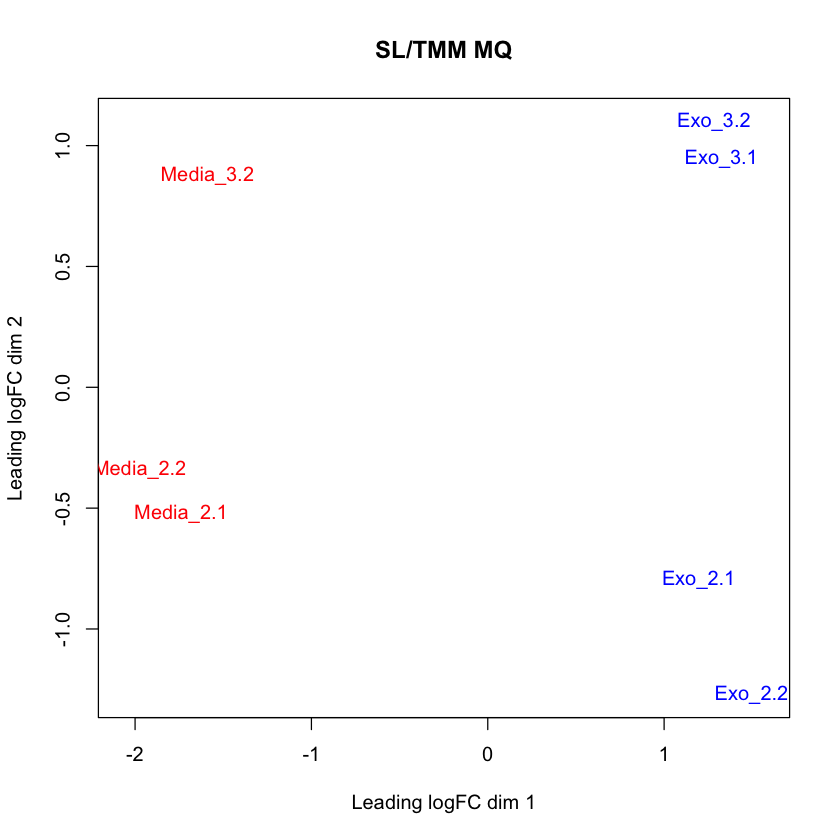

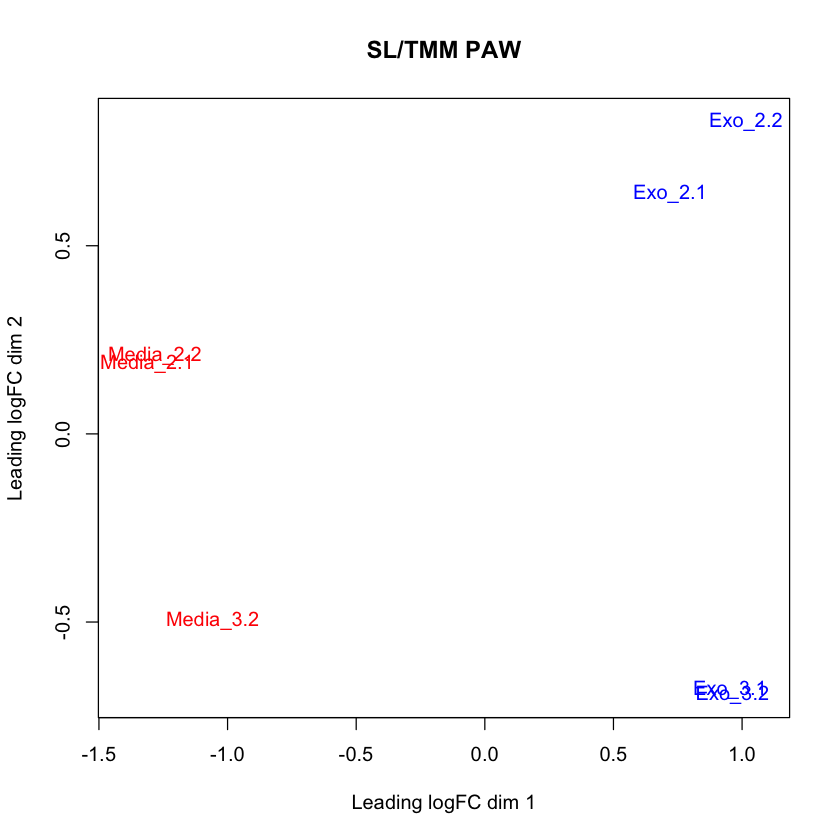

In [100]:
# see how things cluster after we have gotten the boxplots and desity plots looking nice
plotMDS(log2(data_MQ_tmm), col = c(rep("red", 3), rep("blue", 4)), main = "SL/TMM MQ")
plotMDS(log2(data_PAW_tmm), col = c(rep("red", 3), rep("blue", 4)), main = "SL/TMM PAW")

## Clustering also looks similar between MQ and PAW
### Next, check the CV distributions.

In [101]:
# function computes CVs per time point
make_CVs <- function(df) {
  # separate by samples
  media <- df[1:3]
  exo <- df[4:7]
  
  media$ave <- rowMeans(media)
  media$sd <- apply(media[1:3], 1, sd)
  media$cv <- 100 * media$sd / media$ave
  exo$ave <- rowMeans(exo)
  exo$sd <- apply(exo[1:4], 1, sd)
  exo$cv <- 100 * exo$sd / exo$ave  
  ave_df <- data.frame(media$ave, exo$ave)
  sd_df <- data.frame(media$sd, exo$sd)
  cv_df <- data.frame(media$cv, exo$cv)
  return(list(ave_df, sd_df, cv_df))
}

### Compare the CV distributions for the different normalized data

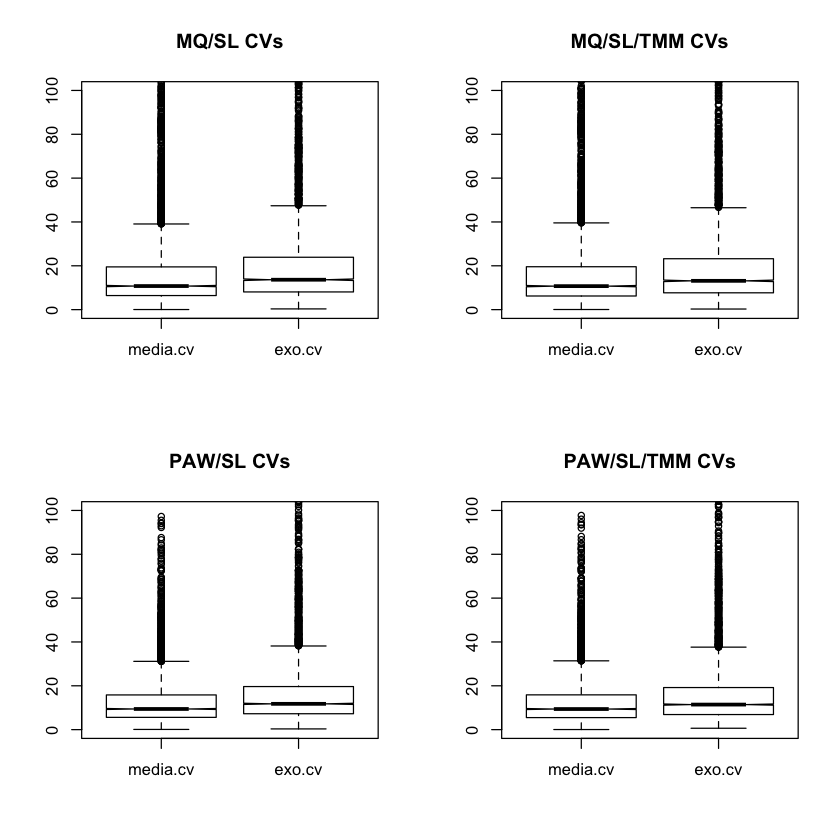

In [102]:
# get CVs and averages
list_MQ_sl <- make_CVs(data_MQ_sl)
list_PAW_sl <- make_CVs(data_PAW_sl)
list_MQ_tmm <- make_CVs(data_MQ_tmm)
list_PAW_tmm <- make_CVs(data_PAW_tmm)

# compare CV distributions
par(mfrow = c(2, 2))
boxplot(list_MQ_sl[[3]], notch = TRUE, main = "MQ/SL CVs", ylim = c(0, 100))
boxplot(list_MQ_tmm[[3]], notch = TRUE, main = "MQ/SL/TMM CVs", ylim = c(0, 100))
boxplot(list_PAW_sl[[3]], notch = TRUE, main = "PAW/SL CVs", ylim = c(0, 100))
boxplot(list_PAW_tmm[[3]], notch = TRUE, main = "PAW/SL/TMM CVs", ylim = c(0, 100))
par(mfrow = c(1, 1))

In [103]:
# print out the average median CVs
print("MQ (%) (SL then SL/TMM):")
(MQ_sl_med_cv <- round(mean(apply(list_MQ_sl[[3]], 2, median)), 2))
(MQ_tmm_med_cv <- round(mean(apply(list_MQ_tmm[[3]], 2, median)), 2))
print("PAW (%) (SL then SL/TMM):")
(PAW_sl_med_cv <- round(mean(apply(list_PAW_sl[[3]], 2, median)),2))
(PAW_tmm_med_cv <- round(mean(apply(list_PAW_tmm[[3]], 2, median)), 2))

[1] "MQ (%) (SL then SL/TMM):"


[1] 12.2

[1] 11.93

[1] "PAW (%) (SL then SL/TMM):"


[1] 10.6

[1] 10.42

## CVs are similar and TMM did not change them much
## Let's compare replicates to each other
MQ looks to be peak heights divided by the number of channels (that is my best guess). We can verify that reporter ion processing is reasonable by comparing the intra-replicate correlations between MQ and PAW.

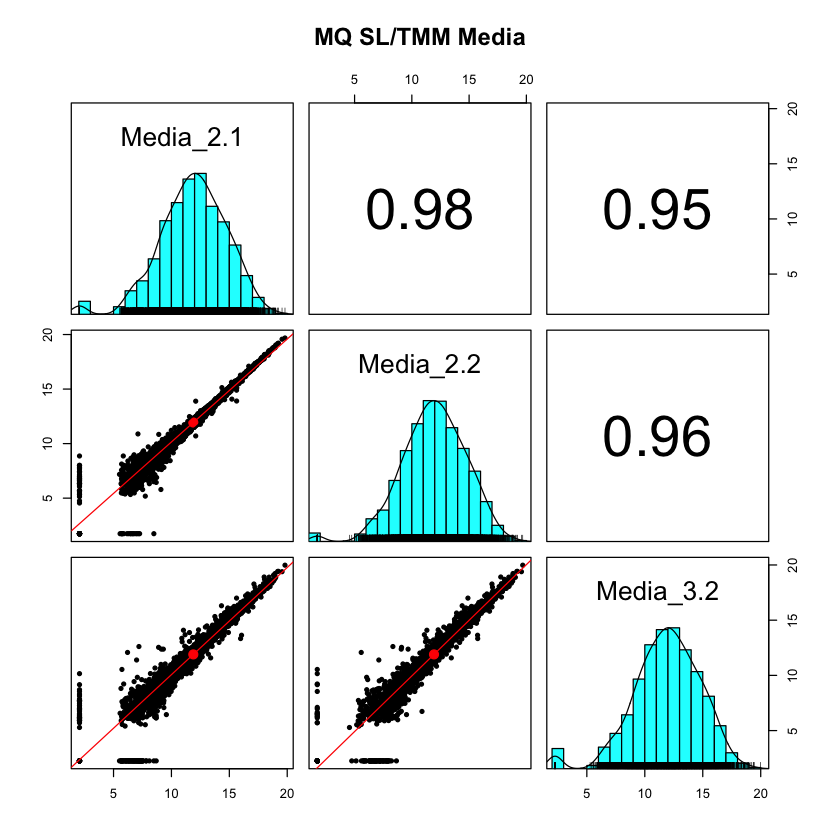

In [104]:
library(psych)
pairs.panels(log2(data_MQ_tmm[1:3]), lm = TRUE, main = "MQ SL/TMM Media")

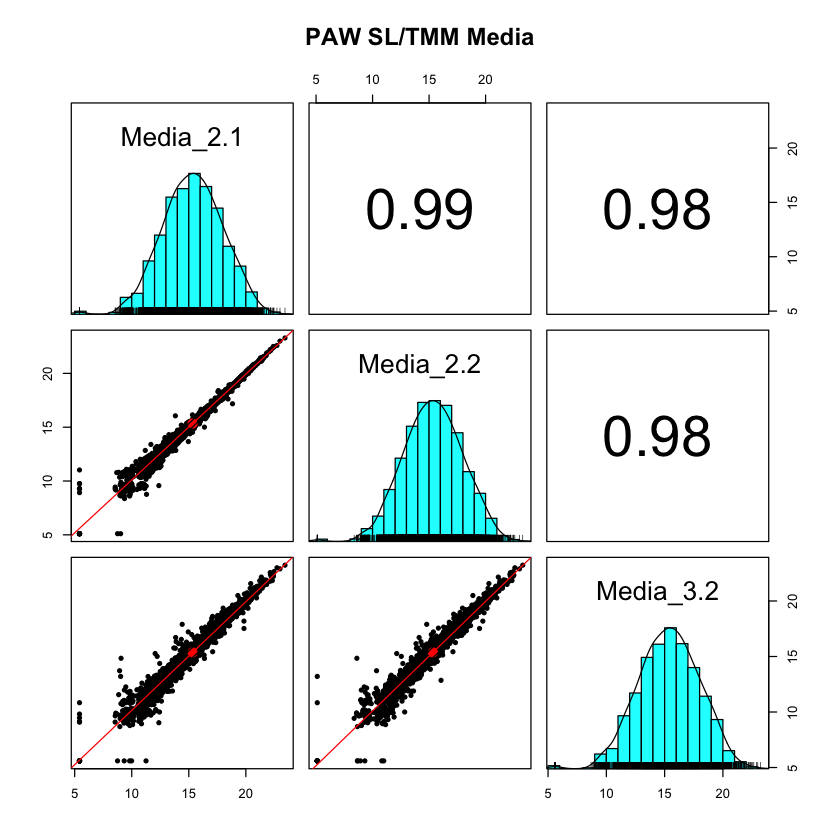

In [105]:
pairs.panels(log2(data_PAW_tmm[1:3]), lm = TRUE, main = "PAW SL/TMM Media")

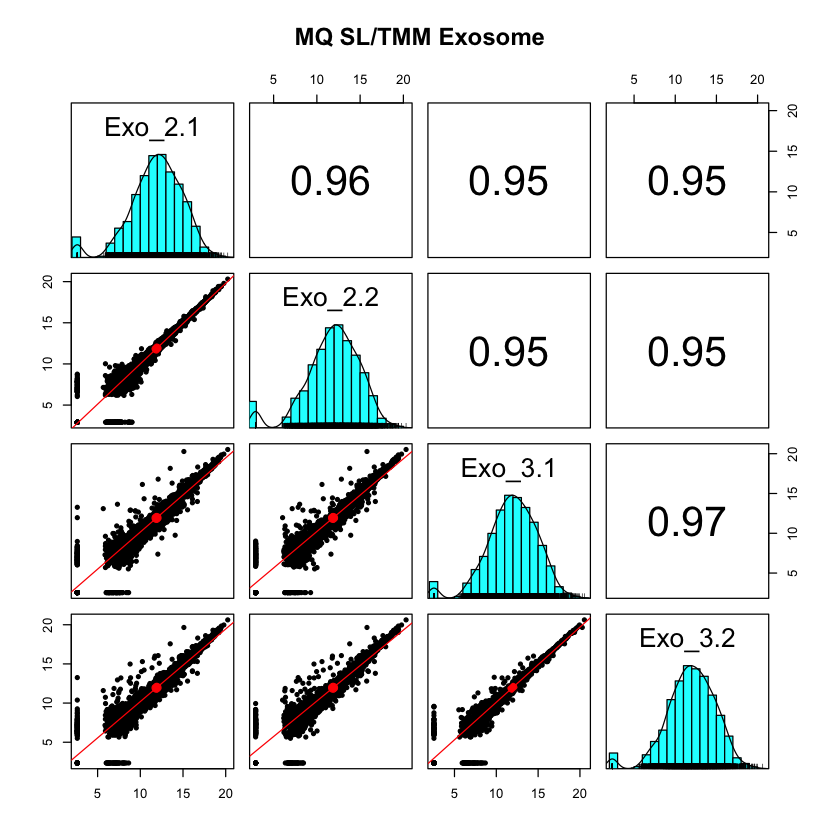

In [106]:
pairs.panels(log2(data_MQ_tmm[4:7]), lm = TRUE, main = "MQ SL/TMM Exosome")

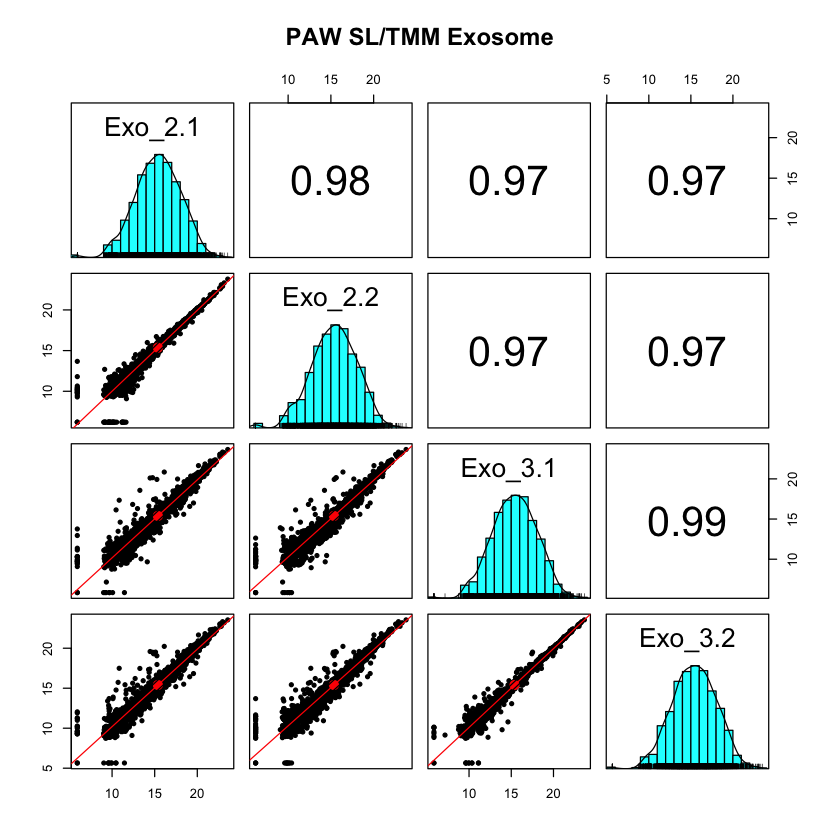

In [107]:
pairs.panels(log2(data_PAW_tmm[4:7]), lm = TRUE, main = "PAW SL/TMM Exosome")

## Generally, replicate-to-replicate comparisons are similar
Let's also compare MQ and PAW protein total intensities to each other. The PAW export was adjusted so that protein accessions were in the same format as MQ reports. We get 4300 common protein out of 4870-ish identified by each. 

In [108]:
df_MQ <- cbind(anno_MQ, data_MQ_tmm)
df_PAW <- cbind(anno_PAW, data_PAW_tmm)
df_both <- merge(df_MQ, df_PAW, by = "Accession")
dim(df_both)
# head(df_both)

[1] 4386   15

## Can MQ and PAW protein level numbers be compared?
The short answer is no. Due to many different factors, each protein in MQ can have a different set of PSMs compared to PAW. The reporter ions can have several orders of magnitude range in intensities. Totals with different numbers of PSMs can have significant differences.

Below, we are comparing within and between pipeline (MQ or PAW) by condition. **Between** pipeline comparisons have greatly increased scatter in contrast to tighter **within** pipeline scatter plots.

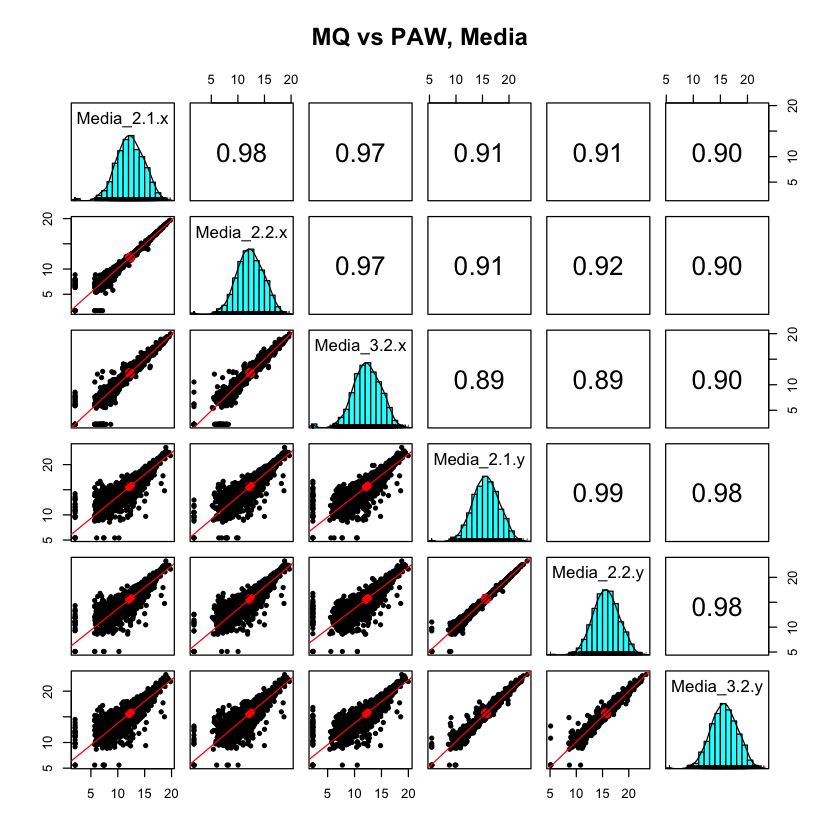

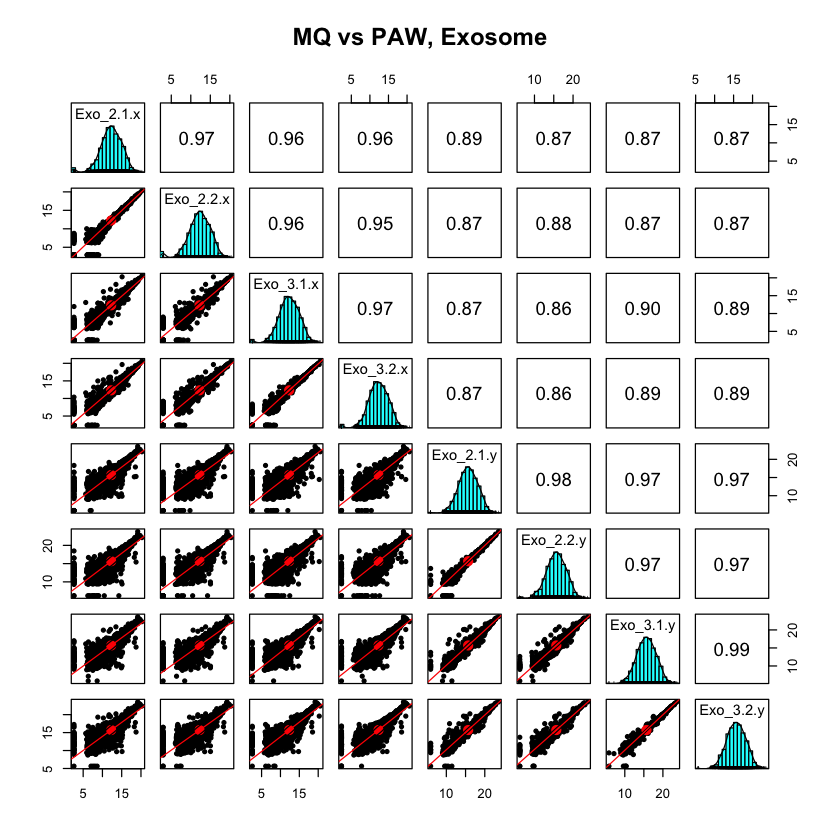

In [109]:
media <- df_both[c(2, 3, 4, 9, 10, 11)]
pairs.panels(log2(media), lm = TRUE, main = "MQ vs PAW, Media")
exo <- df_both[c(5, 6, 7, 8, 12, 13, 14, 15)]
pairs.panels(log2(exo), lm = TRUE, main = "MQ vs PAW, Exosome")

## Look at average media versus average exosome
  

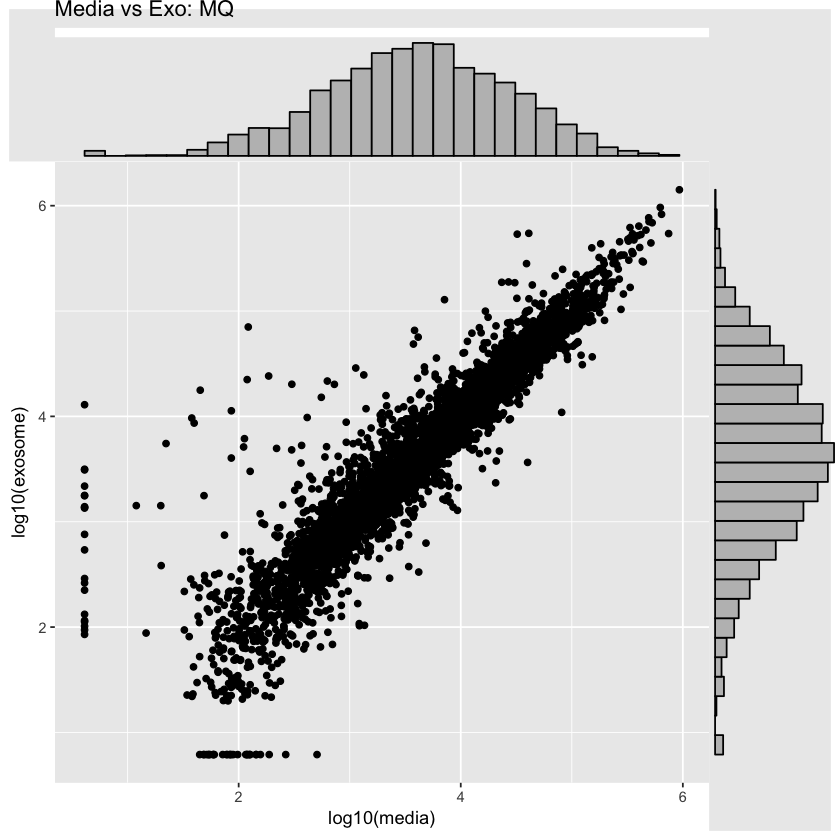

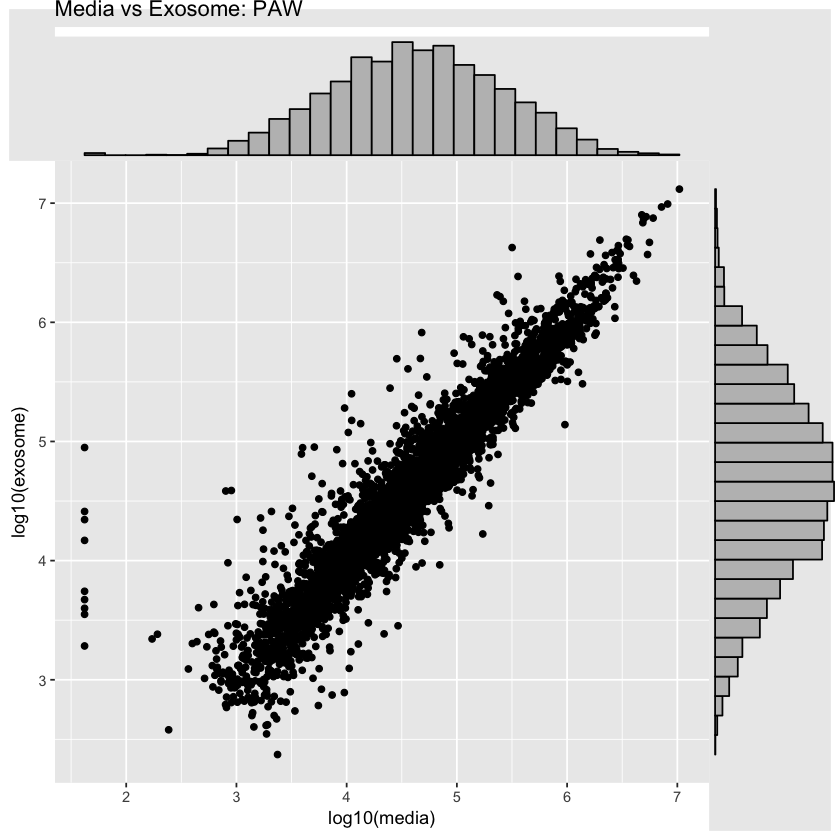

In [110]:
library(ggExtra)

# add marginal distrubution histograms to basic correlation plot (good starting point)
ave_MQ <- data.frame(media = rowMeans(data_MQ_tmm[1:3]), exosome = rowMeans(data_MQ_tmm[4:7]))
ggplot()
corr_plot <- ggplot(ave_MQ, aes(x = log10(media), y = log10(exosome))) +
  geom_point() + ggtitle("Media vs Exo: MQ")
ggMarginal(corr_plot, type = "histogram")

ave_PAW <- data.frame(media = rowMeans(data_PAW_tmm[1:3]), exosome = rowMeans(data_PAW_tmm[4:7]))
ggplot()
corr_plot <- ggplot(ave_PAW, aes(x = log10(media), y = log10(exosome))) +
  geom_point() + ggtitle("Media vs Exosome: PAW")
ggMarginal(corr_plot, type = "histogram")

## On average, both MQ and PAW seem to be behaving well

# Try edgeR on MQ - does the scale of numbers matter?
MaxQuant intensities are roughtly 1/10th the actual peak heights (from XCalibur, Proteome Discoverer, or the direct processing in PAW). MaxQuant does not describe how the reporter ion values are generated. My guess is peak height intensity divided by the number of TMT reagents selected when MQ was run. Do these smaller numbers cause any issues with edgeR? The Poisson component in the negative binomial model used in edgeR will kick in at some point as quantites get smaller. The Poisson variance is relatively smaller when numbers are larger, so the over-dispersion parameter will tend to dominate. 

The typical analysis goes something like this: 
* load the data into edgeR data structures
* run TMM and estimate dispersions
* plot the Biological Coefficient of Variation (BCV)
* do the exact test and get p-values, FDRs
* check the p-value distribution
* perform desired statistical tests
* visualize test results
* collect up normalized data and test results, and write out the table


 Factor w/ 2 levels "media","exo": 1 1 1 2 2 2 2
Design matrix not provided. Switch to the classic mode.


group lib.size norm.factors
Media_2.1 media 92869013 1.0491250   
Media_2.2 media 92869013 1.0685941   
Media_3.2 media 92869013 1.0413223   
Exo_2.1   exo   92869013 0.9863934   
Exo_2.2   exo   92869013 0.9865682   
Exo_3.1   exo   92869013 0.9331750   
Exo_3.2   exo   92869013 0.9432665

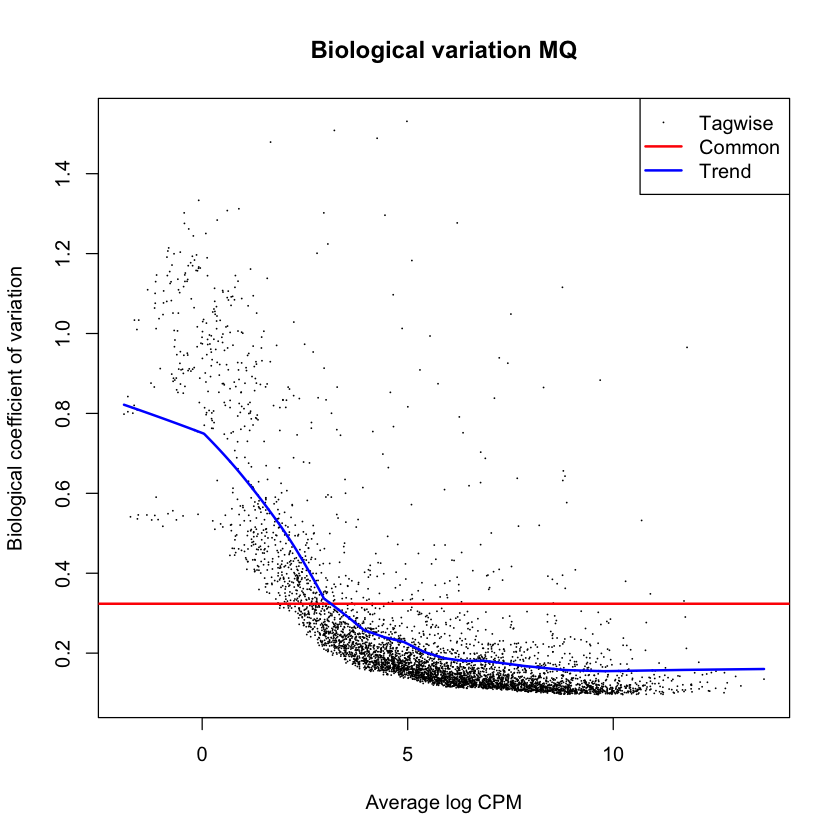

In [111]:
# set up the sample mapping
group <- c(rep("media", 3), rep("exo", 4))

# make group into factors and set the order
group <- factor(group, levels = c("media", "exo"))
str(group)

# create a DGEList object with our data
y_MQ <- DGEList(counts = data_MQ_sl, group = group)
y_MQ <- calcNormFactors(y_MQ)
y_MQ <- estimateDisp(y_MQ)

# y_MQ is a list: y_MQ$counts is the data, and y_MQ$samples has interesting content
y_MQ$samples
plotBCV(y_MQ, main = "Biological variation MQ")

       media+exo
Down         966
NotSig      2896
Up          1002

logFC      logCPM   PValue       FDR          candidate
A0A0B4J1G0  2.2493375 6.074863 3.384741e-19 2.385997e-17 high     
A1L314      2.0253513 8.822280 3.323922e-13 1.130598e-11 high     
A2A432     -0.5636108 5.187919 2.475148e-04 1.195543e-03 high     
A2A4P0     -0.9589363 1.550561 1.356884e-01 2.327181e-01 no       
A2A5R2      1.0028096 7.077859 2.217969e-09 3.694589e-08 high     
Q80Y50      8.7196213 3.456452 4.129234e-29 8.732432e-27 high

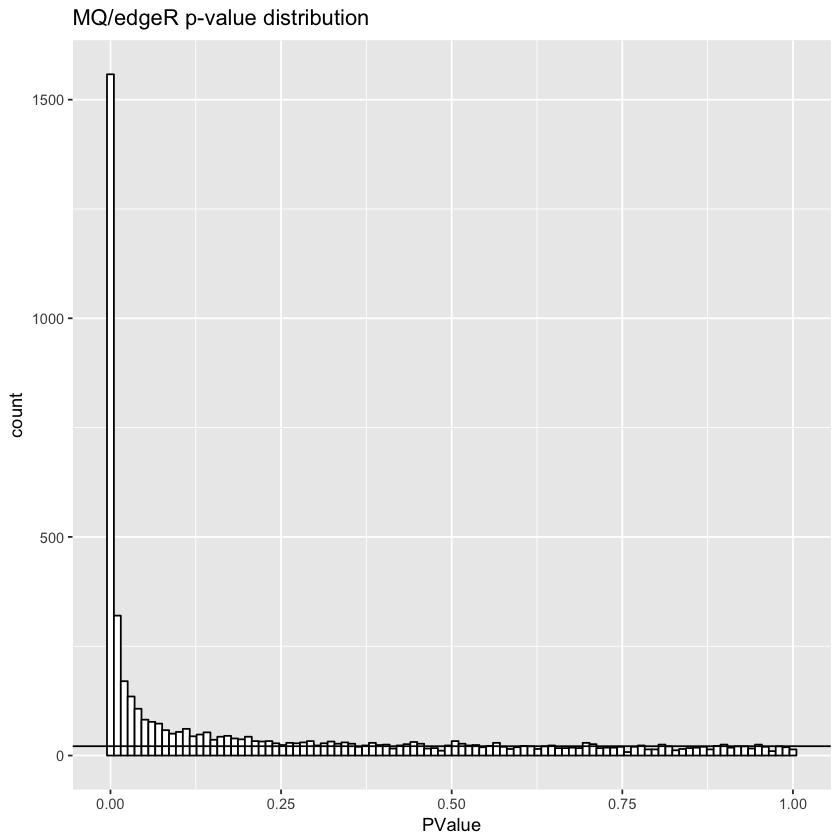

In [112]:
# the exact test object has columns like fold-change, CPM, and p-values
et_MQ <- exactTest(y_MQ, pair = c("media", "exo"))
summary(decideTestsDGE(et_MQ)) # this counts up, down, and unchanged genes (here it is proteins)

# the topTags function adds the BH FDR values to an exactTest data frame. Make sure not to change row order!
tt_MQ <- topTags(et_MQ, n = 10000, sort.by = "none")
tt_MQ <- tt_MQ$table # tt_sl is a list. We just need the data frame table

# add the default value as a new column
tt_MQ$candidate <- "no"
tt_MQ[which(tt_MQ$FDR <= 0.10 & tt_MQ$FDR > 0.05), dim(tt_MQ)[2]] <- "low"
tt_MQ[which(tt_MQ$FDR <= 0.05 & tt_MQ$FDR > 0.01), dim(tt_MQ)[2]] <- "med"
tt_MQ[which(tt_MQ$FDR <= 0.01), dim(tt_MQ)[2]] <- "high"
tt_MQ$candidate <- factor(tt_MQ$candidate, levels = c("high", "med",  "low", "no"))

# what does tt_MQ look like?
head(tt_MQ)

# what does the test p-value distribution look like?
ggplot(tt_MQ, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(tt_MQ$PValue, breaks = 100, plot = FALSE)$counts[26:100])) +
  ggtitle("MQ/edgeR p-value distribution")

## PAW data

Design matrix not provided. Switch to the classic mode.


group lib.size  norm.factors
Media_2.1 media 888496741 1.0310378   
Media_2.2 media 888496741 1.0393370   
Media_3.2 media 888496741 1.0258469   
Exo_2.1   exo   888496741 1.0016254   
Exo_2.2   exo   888496741 1.0033950   
Exo_3.1   exo   888496741 0.9501978   
Exo_3.2   exo   888496741 0.9525662

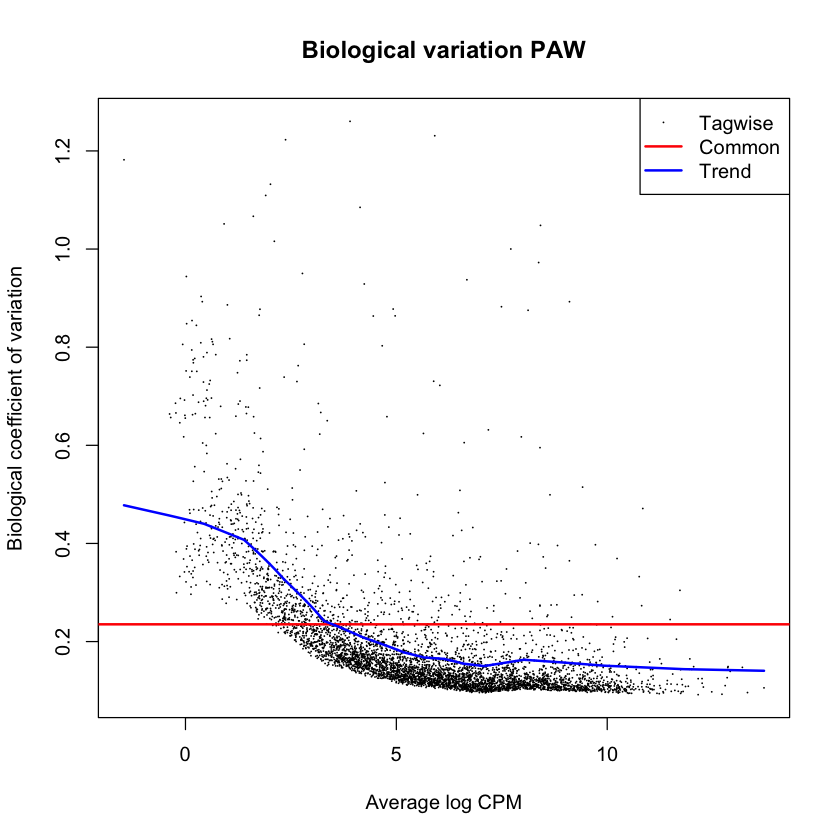

In [113]:
# create a DGEList object with our data
y_PAW <- DGEList(counts = data_PAW_sl, group = group)
y_PAW <- calcNormFactors(y_PAW)
y_PAW <- estimateDisp(y_PAW)

# y_PAW is a list: y_PAW$counts is the data, and y_PAW$samples has interesting content
y_PAW$samples
plotBCV(y_PAW, main = "Biological variation PAW")

       media+exo
Down        1022
NotSig      2827
Up          1031

logFC      logCPM   PValue       FDR          candidate
A0A0B4J1G0  2.1334942 5.692575 5.913425e-18 3.069948e-16 high     
A1L314      1.6194120 9.017670 4.840078e-12 1.230186e-10 high     
A2A432     -0.5285308 5.252394 5.120794e-04 2.105263e-03 high     
A2A4P0      0.2375578 4.172903 3.394859e-01 4.613261e-01 no       
A2A5R2      0.7656244 7.092717 2.368108e-09 3.703964e-08 high     
A2A6Q5     -0.1426184 2.616548 5.310715e-01 6.458084e-01 no

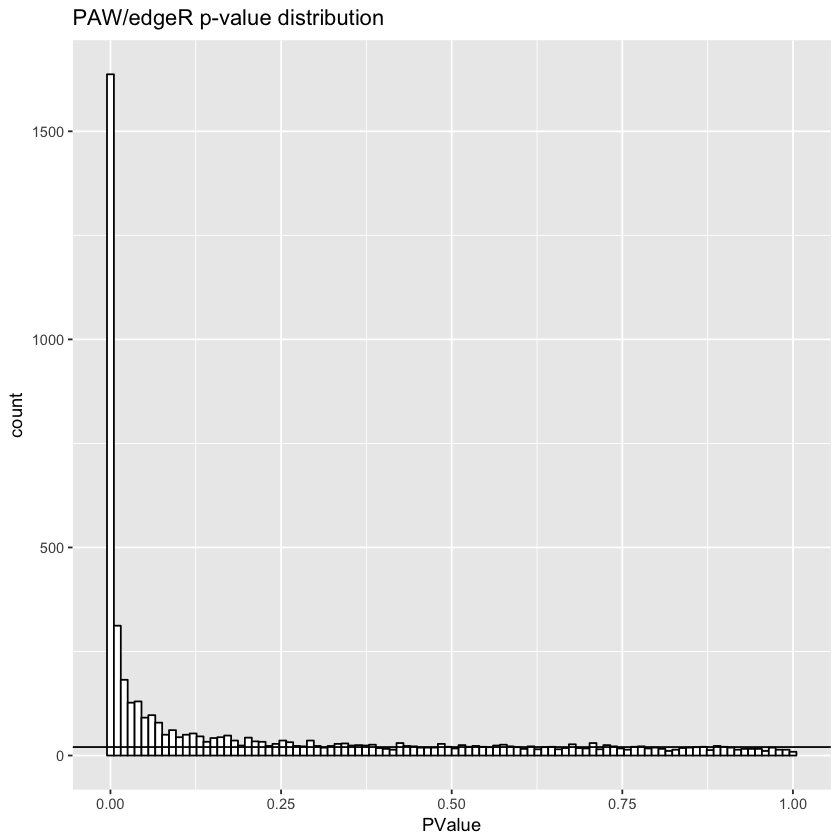

In [114]:
# the exact test object has columns like fold-change, CPM, and p-values
et_PAW <- exactTest(y_PAW, pair = c("media", "exo"))
summary(decideTestsDGE(et_PAW)) # this counts up, down, and unchanged genes (here it is proteins)

# the topTags function adds the BH FDR values to an exactTest data frame. Make sure not to change row order!
tt_PAW <- topTags(et_PAW, n = 10000, sort.by = "none")
tt_PAW <- tt_PAW$table # tt_PAW is a list. We just need the data frame table

# add the default value as a new column
tt_PAW$candidate <- "no"
tt_PAW[which(tt_PAW$FDR <= 0.10 & tt_PAW$FDR > 0.05), dim(tt_PAW)[2]] <- "low"
tt_PAW[which(tt_PAW$FDR <= 0.05 & tt_PAW$FDR > 0.01), dim(tt_PAW)[2]] <- "med"
tt_PAW[which(tt_PAW$FDR <= 0.01), dim(tt_PAW)[2]] <- "high"
tt_PAW$candidate <- factor(tt_PAW$candidate, levels = c("high", "med",  "low", "no"))

# what does tt_sl look like?
head(tt_PAW)

# what does the test p-value distribution look like?
ggplot(tt_PAW, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(tt_PAW$PValue, breaks = 100, plot = FALSE)$counts[26:100])) +
  ggtitle("PAW/edgeR p-value distribution")

## Visualize the edgeR results for MQ
* make the volcano plot frame
* look at MA plots
* look at scatter plots
* look at volcano plot

We will make some plotting functions to simplify the processing. We will be calling these multiple times.

In [115]:
# We need one extra library
library(scales)

# function for MA plots
pw_ma_plot <- function(frame, x, y, f, title) {
  # frame = data frame with data
  # x, y are the string names of the x and y columns
  # f is the factor for faceting, title is a string for plot titles
  # make the main MA plot
  temp <- data.frame(log2((frame[x] + frame[y])/2), log2(frame[y] / frame[x]), frame[f])
  colnames(temp) <- c("Ave", "FC", "candidate")
  first  <- ggplot(temp, aes(x = Ave, y = FC)) +
    geom_point(aes(color = candidate, shape = candidate)) +
    scale_y_continuous(paste0("logFC (", x, "/", y, ")")) +
    scale_x_continuous("Ave_intensity") +
    ggtitle(title) + 
    geom_hline(yintercept = 0.0, color = "black") + # one-to-one line
    geom_hline(yintercept = 1.0, color = "black", linetype = "dotted") + # 2-fold up
    geom_hline(yintercept = -1.0, color = "black", linetype = "dotted") # 2-fold down

  # make separate MA plots
  second <- ggplot(temp, aes(x = Ave, y = FC)) +
    geom_point(aes(color = candidate, shape = candidate)) +
    scale_y_continuous(paste0("logFC (", x, "/", y, ")")) +
    scale_x_continuous("Ave_intensity") +
    geom_hline(yintercept = 0.0, color = "black") + # one-to-one line
    geom_hline(yintercept = 1.0, color = "black", linetype = "dotted") + # 2-fold up
    geom_hline(yintercept = -1.0, color = "black", linetype = "dotted") + # 2-fold down
    facet_wrap(~ candidate) +
    ggtitle(paste(title, "(separated)", sep=" "))
    
  print(first)
  print(second)
}

pw_scatter_plot <- function(frame, X, Y, f, title) {
  # frame = data frame with data
  # x, y are the string names of the x and y columns
  # f is the factor for faceting, title is a string for plot titles
  # make the combined candidate corelation plot
  first <- ggplot(frame, aes_string(X, Y)) +
    geom_point(aes_string(color = f, shape = f)) +
    scale_y_log10() +
    scale_x_log10() +
    ggtitle(title) + 
    geom_abline(intercept = 0.0, slope = 1.0, color = "black") + # one-to-one line
    geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted") + # 2-fold up
    geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted") # 2-fold down

  # make separate corelation plots
  second <- ggplot(frame, aes_string(X, Y)) +
    geom_point(aes_string(color = f, shape = f)) +
    scale_y_log10() +
    scale_x_log10() +
    geom_abline(intercept = 0.0, slope = 1.0, color = "black") + # one-to-one line
    geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted") + # 2-fold up
    geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted") + # 2-fold down
    facet_wrap(~ candidate) +
    ggtitle(paste(title, "(separated)", sep=" ")) 
    
  print(first)
  print(second)
}

## We will categorize differential expression (DE) candidates based on FDR

* "no" are proteins with FDR > 0.10
* "low" are 0.10 >= FDR > 0.05
* "med" are 0.05 >= FDR > 0.01
* and "high" have 0.01 >= FDR

FoldChange FDR        candidate
1  2.2493998 16.6223301 high     
2  2.0253605 10.9466917 high     
3 -0.5636031  2.9224347 high     
4 -0.9591335  0.6331698 no       
5  1.0028054  7.4324338 high     
6  8.7616519 26.0588648 high

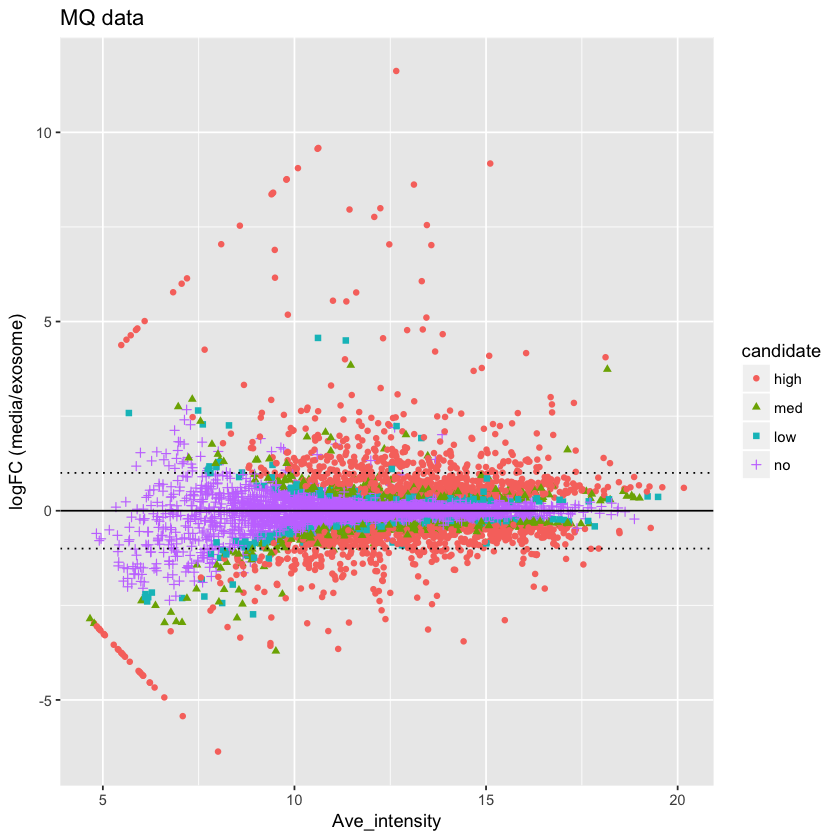

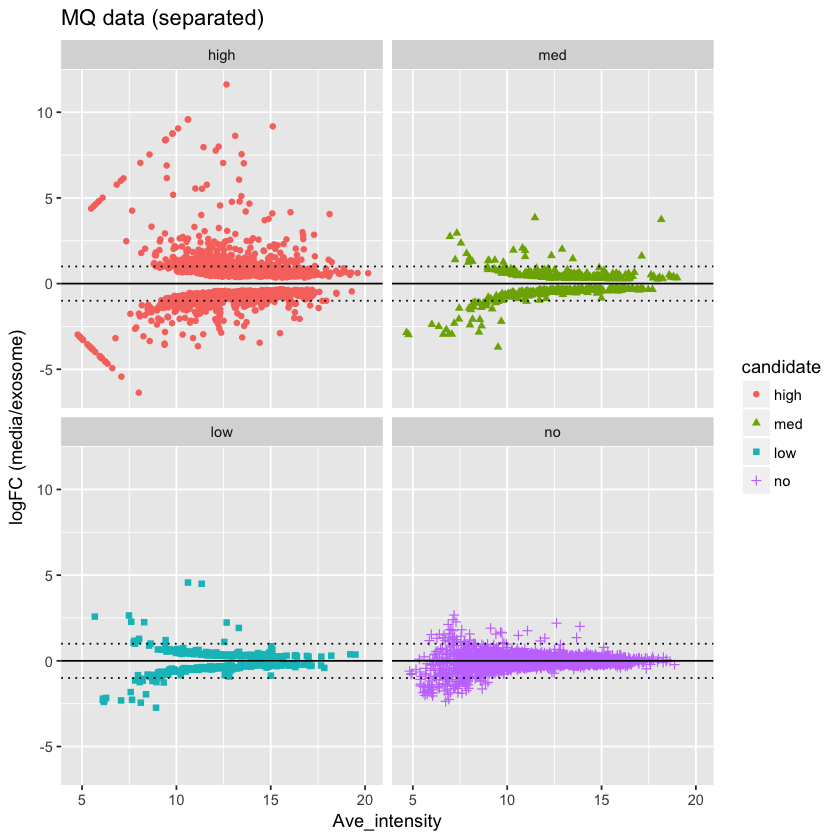

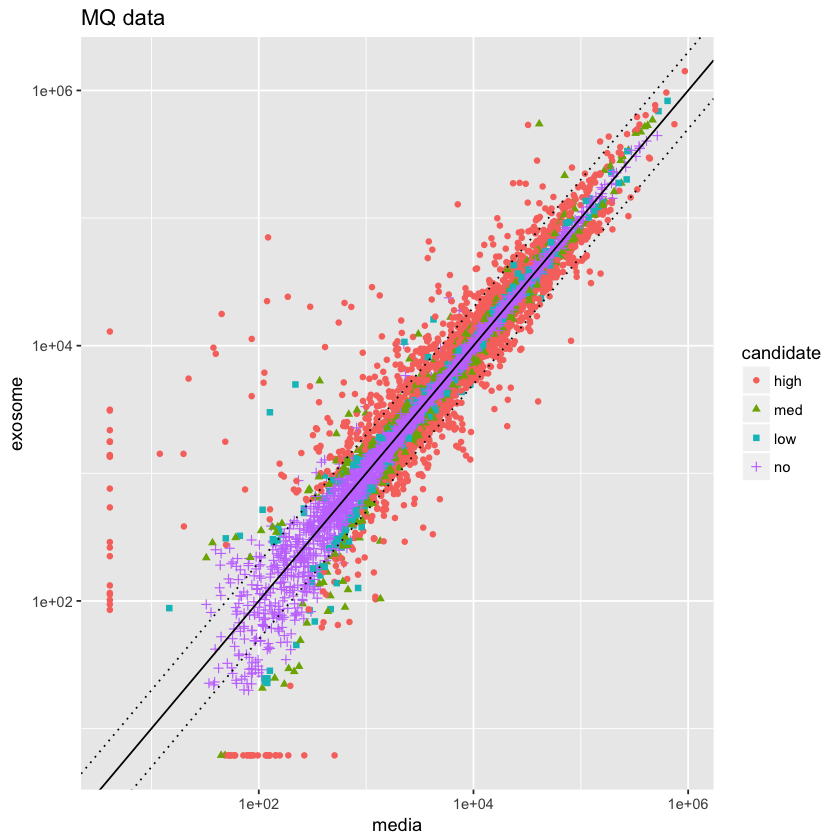

Warning message:
“Removed 6 rows containing missing values (geom_point).”

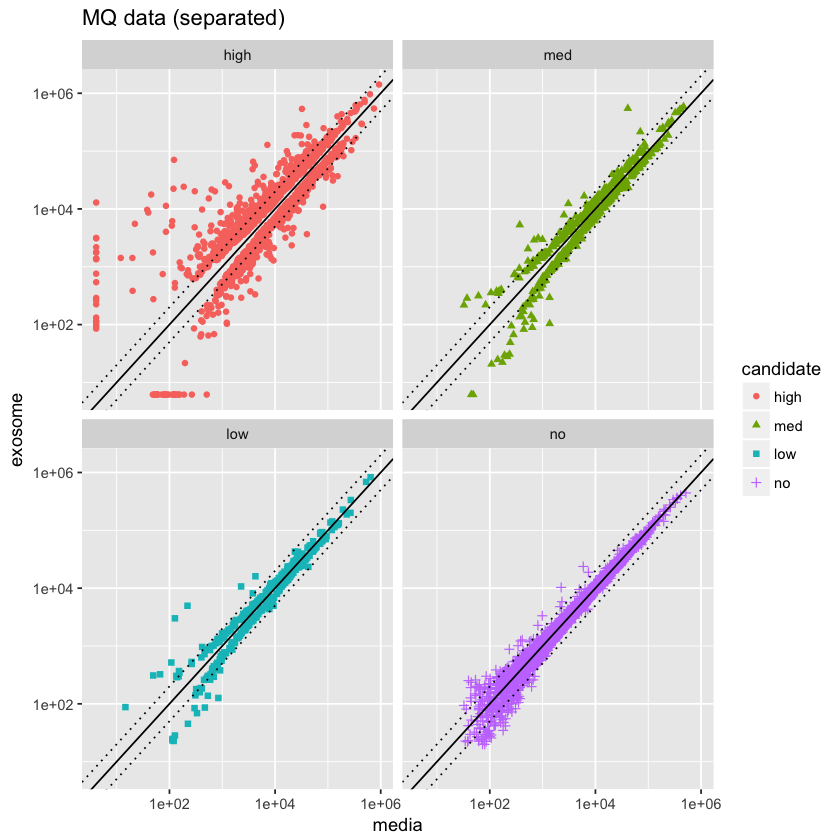

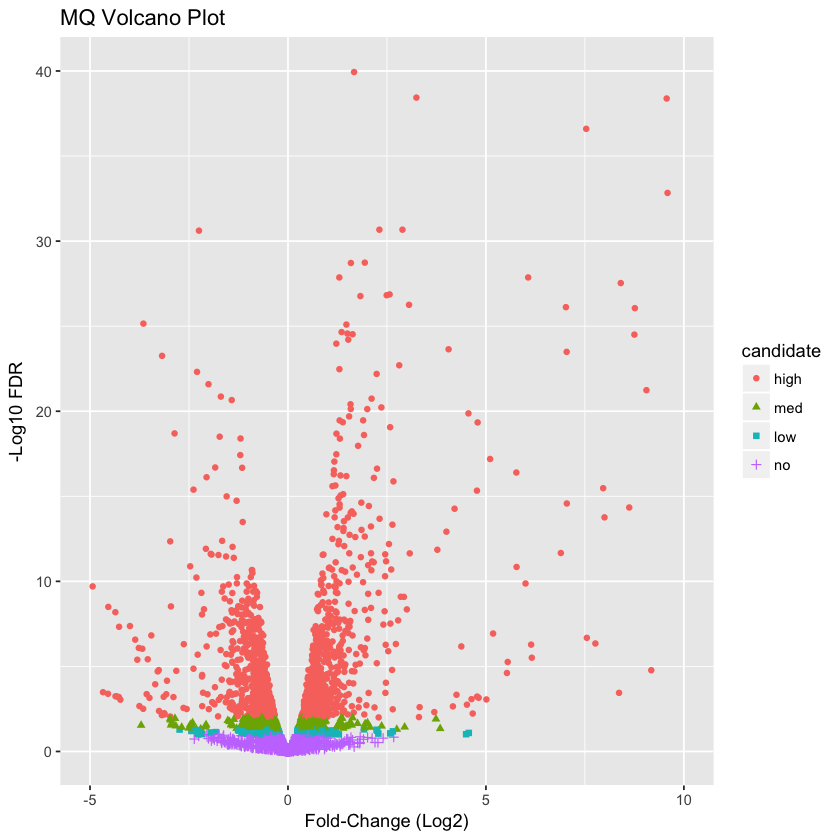

In [116]:
# for plotting results, we will use the average intensities for the samples
ave_MQ$candidate <- tt_MQ$candidate
volcano_MQ <- data.frame(log2(ave_MQ$exosome / ave_MQ$media), log10(tt_MQ$FDR)*(-1), ave_MQ$candidate)
colnames(volcano_MQ) <- c("FoldChange", "FDR", "candidate")
head(volcano_MQ)

# start with MA plot
pw_ma_plot(ave_MQ, "media", "exosome", "candidate", "MQ data")
# now the scatter plot
pw_scatter_plot(ave_MQ, "media", "exosome", "candidate", "MQ data")

# make a volcano plot
ggplot(volcano_MQ, aes(x = FoldChange, y = FDR)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  xlab("Fold-Change (Log2)") +
  ylab("-Log10 FDR") +
  ylim(c(NA, 40)) +
  xlim(c(-5, 10)) +
  ggtitle("MQ Volcano Plot")

## Now look at PAW data
* make the volcano plot frame
* look at MA plots
* look at scatter plots
* look at volcano plot

FoldChange FDR        candidate
1  2.1335038 15.5128690 high     
2  1.6194128  9.9100290 high     
3 -0.5285279  2.6766936 high     
4  0.2375686  0.3359919 no       
5  0.7656234  7.4313332 high     
6 -0.1426176  0.1898963 no

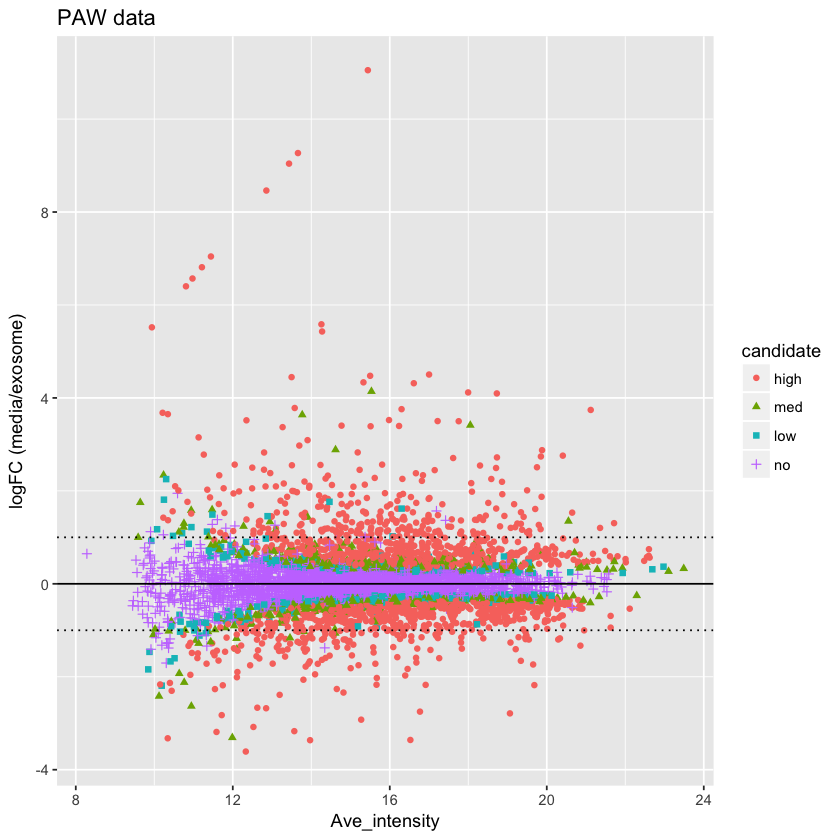

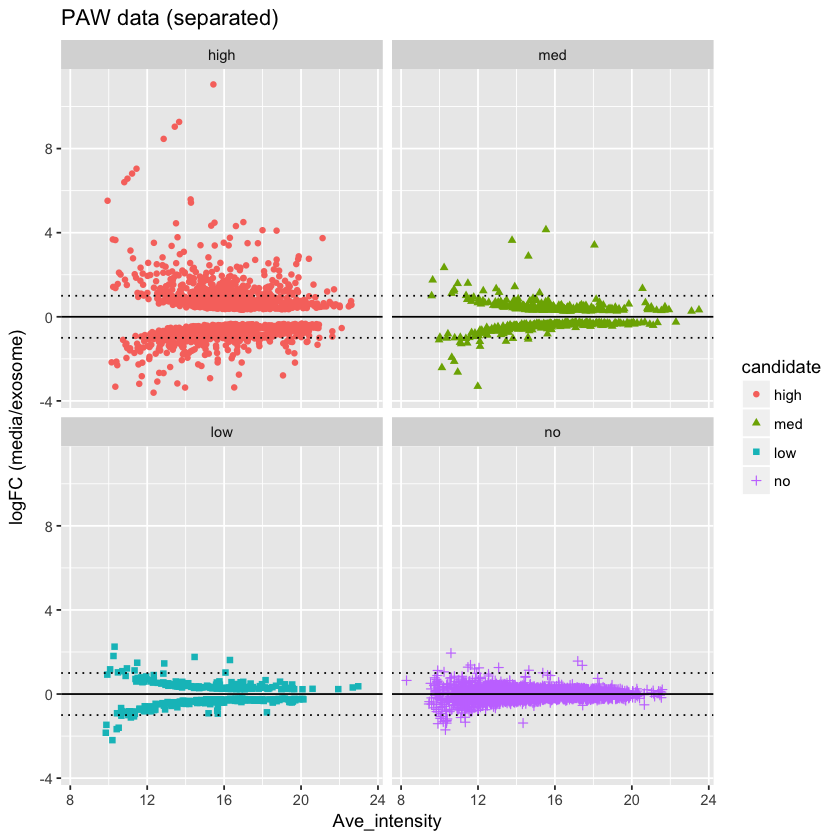

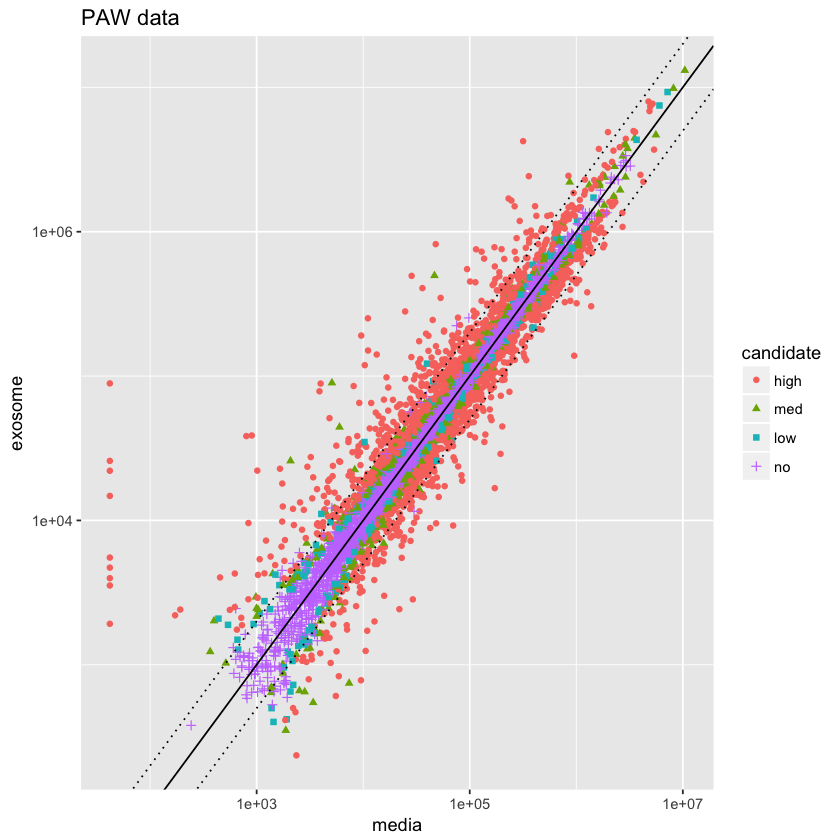

Warning message:
“Removed 8 rows containing missing values (geom_point).”

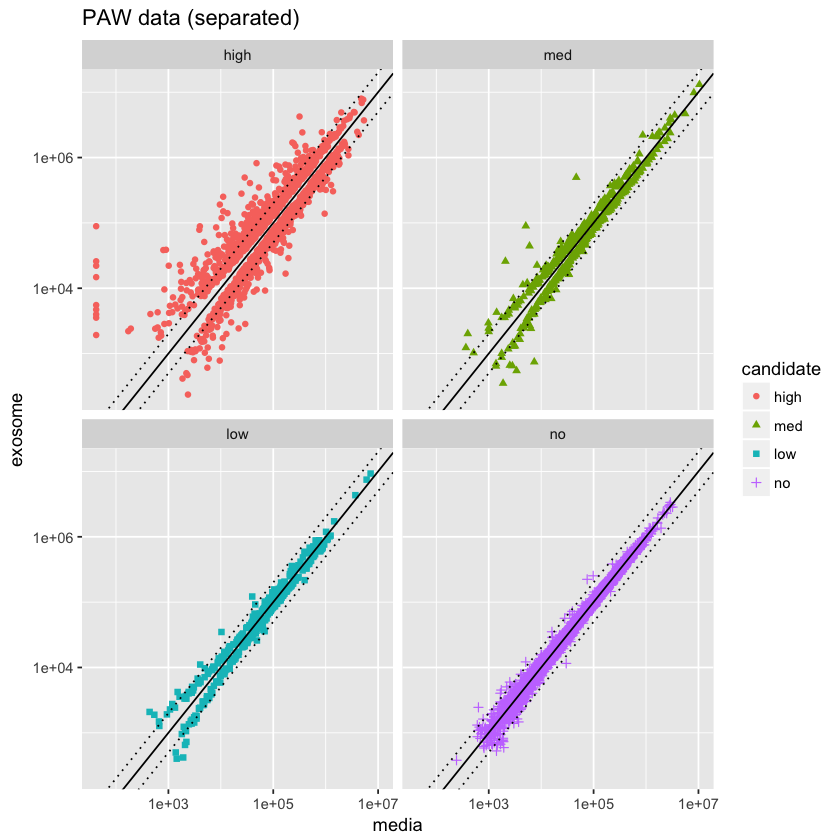

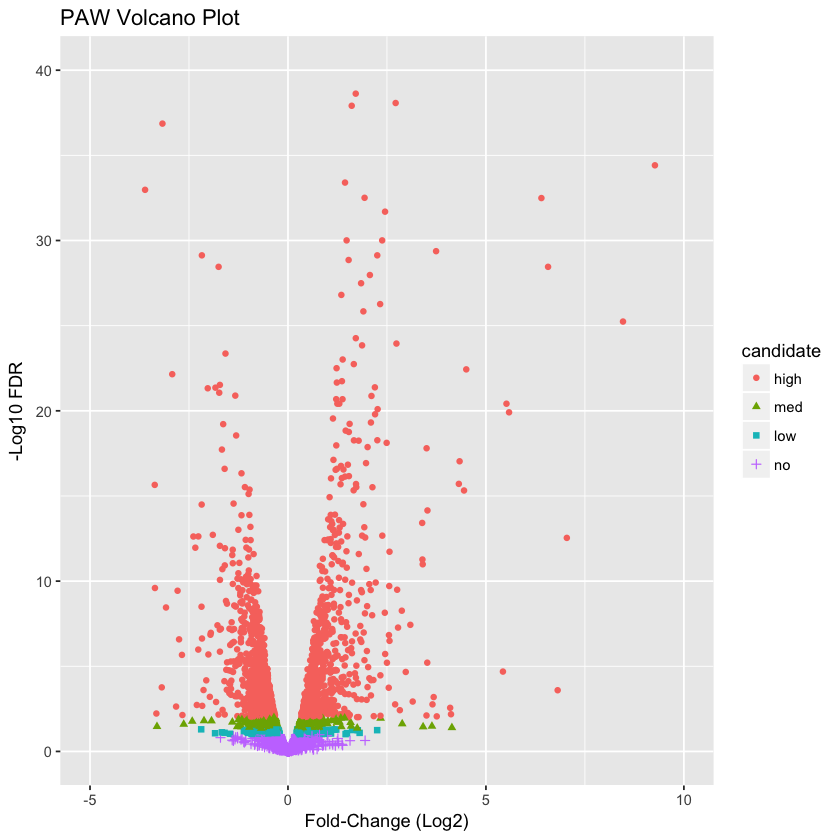

In [117]:
# for plotting results, we will use the average intensities for the samples
ave_PAW$candidate <- tt_PAW$candidate
volcano_PAW <- data.frame(log2(ave_PAW$exosome / ave_PAW$media), log10(tt_PAW$FDR)*(-1), ave_PAW$candidate)
colnames(volcano_PAW) <- c("FoldChange", "FDR", "candidate")
head(volcano_PAW)

# start with MA plot
pw_ma_plot(ave_PAW, "media", "exosome", "candidate", "PAW data")
# now the scatter plot
pw_scatter_plot(ave_PAW, "media", "exosome", "candidate", "PAW data")

# make a volcano plot
ggplot(volcano_PAW, aes(x = FoldChange, y = FDR)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  xlab("Fold-Change (Log2)") +
  ylab("-Log10 FDR") +
  ylim(c(NA, 40)) +
  xlim(c(-5, 10)) +
  ggtitle("PAW Volcano Plot")

In [118]:
summary(ave_MQ$candidate)
summary(ave_PAW$candidate)

high  med  low   no 
1438  530  344 2552

high  med  low   no 
1545  508  373 2454

# Summary
## MQ and PAW data seem comparable
* data before and after normalizations were qualitatively similar
* sample replicate-to-replicate scatter plots were also qualitatively similar
* PAW processing had fewer missing data values and the data were a bit tighter
* the MA plots, scatter plots, and volcano plot seem to have better separation by candidate category with PAW data
* protein grouping in PAW is probably better than razor peptide approach in MQ

## edgeR seems to work fine with MQ data
edgeR has a Poisson component that will depend on the magnitude of the numbers being tested. MQ values are about 10 times smaller than PAW values. However, edgeR results seemed to be qualitatively very similar. The up- and down-regulated numbers were similar, as were the numbers in the different candidate categories. Limma may still be a more appropriate package than edgeR for TMT data, but it seems that edgeR is not having any issues with either PAW or MQ data. 

## Getting data into and out of R
There is more data preparation necessary for MQ summary files that for PAW files. With either pipeline, prepping the data in Excel before working in R seems easier. Care much be taken to make sure the results from the R analysis can be merged back with the main summary files. Using the protein accession as a key is a good strategy. 
<br><br>[NOTE: exported data was easily added back to proteinGroups sheet. Everything stayed in the original order during the R processing.] 

In [119]:
final_MQ_frame <- cbind(anno_MQ, data_MQ_tmm, tt_MQ)
write.csv(final_MQ_frame, file = "final_MQ_frame.csv")

<br>
# One last thing...
<br>
## Let's see how a basic t-test works with the MQ data
The best statistical option in Perseus is probably a two-sample t-test with a multiple testing correction. Let's see how that compares to the edgeR analysis. We will use the shared variance option on the t-test to get a little more variance pooling.

Media_2.1 Media_2.2 Media_3.2 Exo_2.1   Exo_2.2   Exo_3.1  
A0A0B4J1G0 10.837337 10.678340 11.287945 12.837133 12.951952 13.446518
A1L314     13.719520 13.668404 14.233965 15.492162 15.491091 16.237122
A2A432     12.015870 12.093459 11.943538 11.454585 11.341808 11.412210
A2A4P0      7.554548  8.890845  8.839845  6.778628  7.137829  8.692785
A2A5R2     12.822723 12.952641 13.093835 14.076816 14.180612 13.751883
Q80Y50      2.060773  1.740996  2.255183 11.360316 11.413911  9.820312
           Exo_3.2   ave_media    ave_exo    logFC      p_value     
A0A0B4J1G0 13.481274  1989.579769  9460.1531  2.2493998 2.803648e-04
A1L314     16.271162 15259.162539 62119.0717  2.0253605 1.170826e-03
A2A432     11.600162  4150.075140  2807.9832 -0.5636031 6.106161e-04
A2A4P0      6.704690   373.629715   192.1823 -0.9591335 1.565773e-01
A2A5R2     13.798926  7971.580970 15974.1946  1.0028054 8.532666e-04
Q80Y50      9.731165     4.096235  1777.8898  8.7616519 2.268388e-05
           fdr         candidate
A0A0B4J1G0 0.005065529 high     
A1L314     0.009428638 high     
A2A432     0.007385838 high     
A2A4P0     0.243009504 no       
A2A5R2     0.008251022 high     
Q80Y50     0.001739235 high

[1] "This is like the decideTest in edgeR - 5% FDR cut:"


[1] 916

[1] 3049

[1] 899

[1] "Candidate Counts:"


high  med  low   no 
 638 1177  538 2511

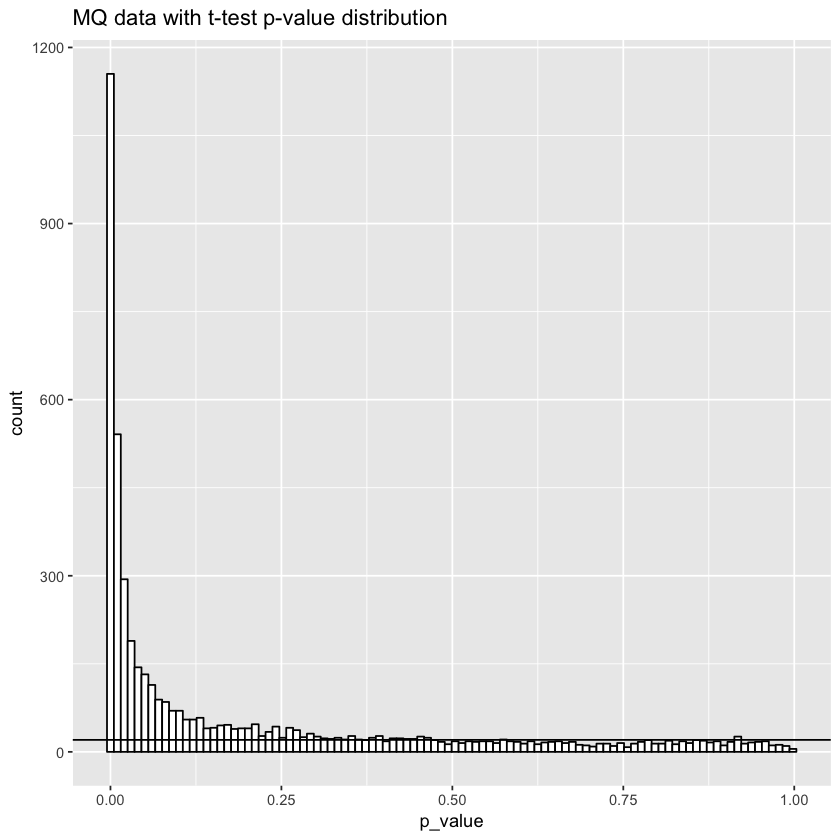

In [120]:
# do the t-test on log transformed intensities to be safe
ttest_MQ <- log2(data_MQ_tmm)
# add average ratio columns (non-logged ratios), fold-change column, and row names
ttest_MQ$ave_media <- rowMeans(data_MQ_tmm[1:3])
ttest_MQ$ave_exo  <- rowMeans(data_MQ_tmm[4:7])
ttest_MQ$logFC <- log2(ttest_MQ$ave_exo / ttest_MQ$ave_media)
row.names(ttest_MQ) <- anno_MQ$Accession

# apply the basic two-sample t-test (we will pool variance)
t.result <- apply(ttest_MQ, 1, function(x) t.test(x[1:3], x[4:7], var.equal = TRUE))
# extract the p-value column from the t-test thingy 
ttest_MQ$p_value <- unlist(lapply(t.result, function(x) x$p.value))
# do a Benjamini-Hochberg multiple testing correction
ttest_MQ$fdr <- p.adjust(ttest_MQ$p_value, method = "BH")

# add a DE candidate status column
ttest_MQ$candidate <- "no"
ttest_MQ[which(ttest_MQ$fdr <= 0.10 & ttest_MQ$fdr > 0.05), dim(ttest_MQ)[2]] <- "low"
ttest_MQ[which(ttest_MQ$fdr <= 0.05 & ttest_MQ$fdr > 0.01), dim(ttest_MQ)[2]] <- "med"
ttest_MQ[which(ttest_MQ$fdr <= 0.01), dim(ttest_MQ)[2]] <- "high"
ttest_MQ$candidate <- factor(ttest_MQ$candidate, levels = c("high", "med",  "low", "no"))
head(ttest_MQ)
    
# count up, down and the rest (FDR less than 0.05)
all <- dim(ttest_MQ)[1]
up <- dim(ttest_MQ[(ttest_MQ$fdr <= 0.05) & (ttest_MQ$logFC > 0.0), ])[1]
down <- dim(ttest_MQ[(ttest_MQ$fdr <= 0.05) & (ttest_MQ$logFC <= 0.0), ])[1]
print("This is like the decideTest in edgeR - 5% FDR cut:")
up 
all - up - down
down
print("Candidate Counts:")
summary(ttest_MQ$candidate)
    
# what does the test p-value distribution look like?
ggplot(ttest_MQ, aes(p_value)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(tt_PAW$PValue, breaks = 100, plot = FALSE)$counts[26:100])) +
  ggtitle("MQ data with t-test p-value distribution")

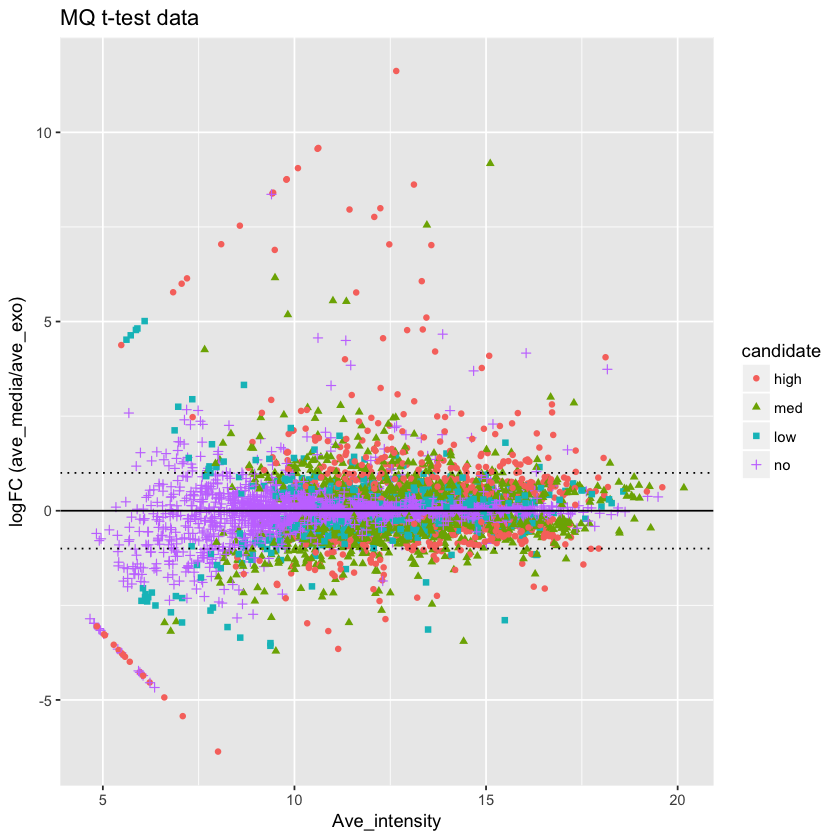

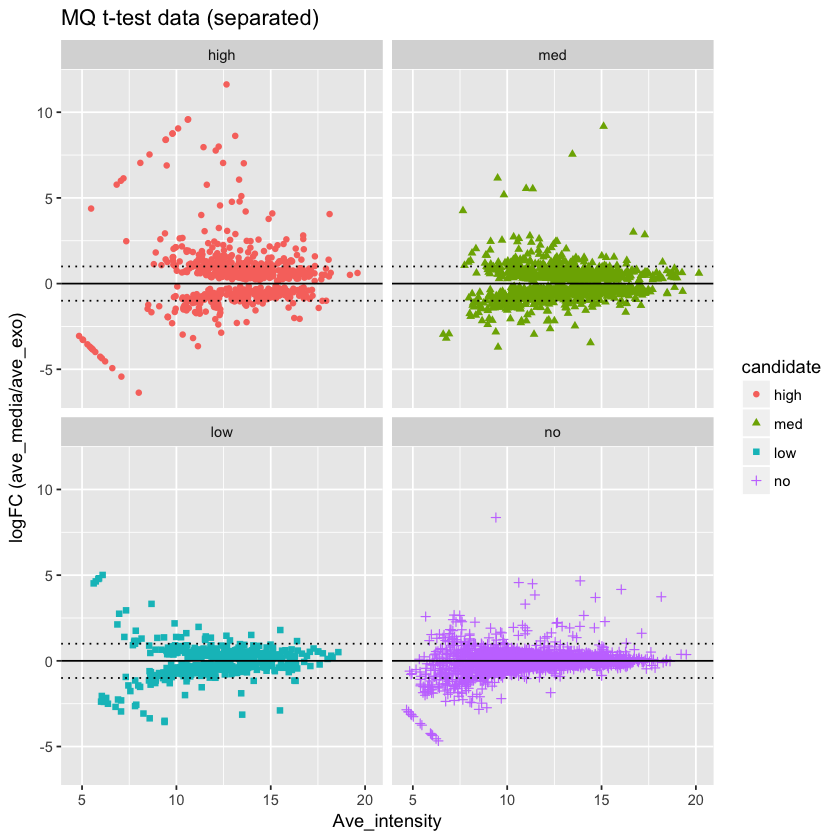

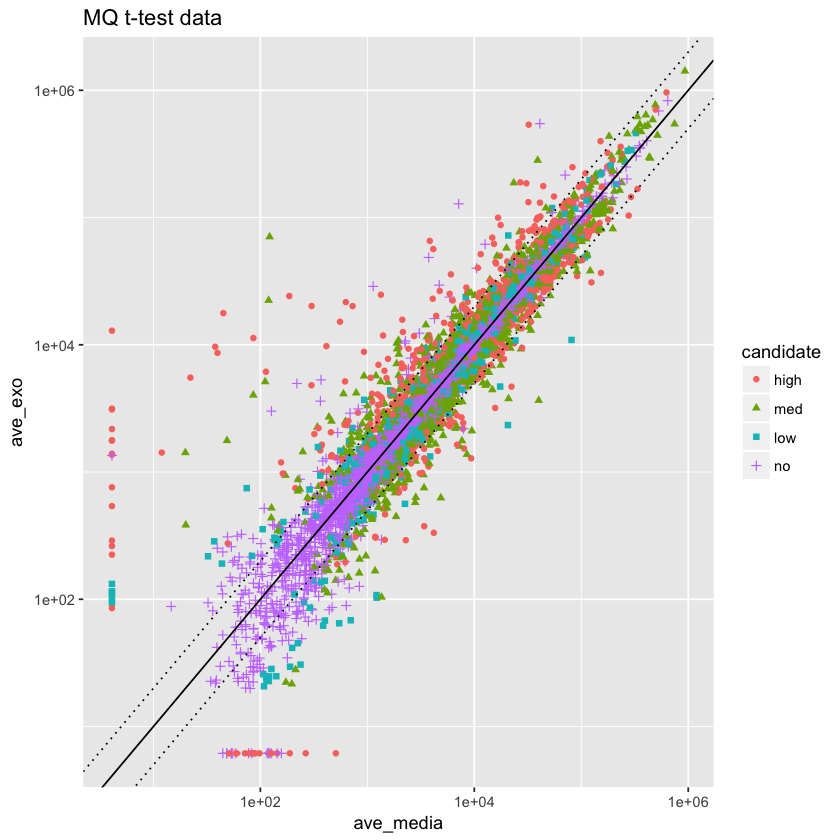

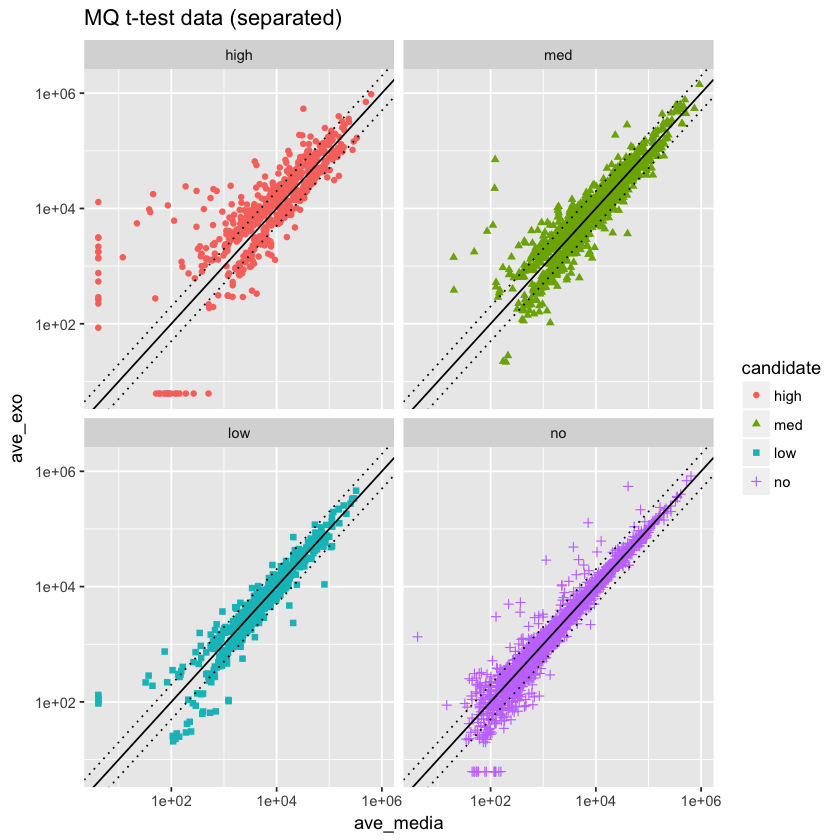

In [121]:
# start with MA plot
pw_ma_plot(ttest_MQ, "ave_media", "ave_exo", "candidate", "MQ t-test data")
# now the scatter plot
pw_scatter_plot(ttest_MQ, "ave_media", "ave_exo", "candidate", "MQ t-test data")

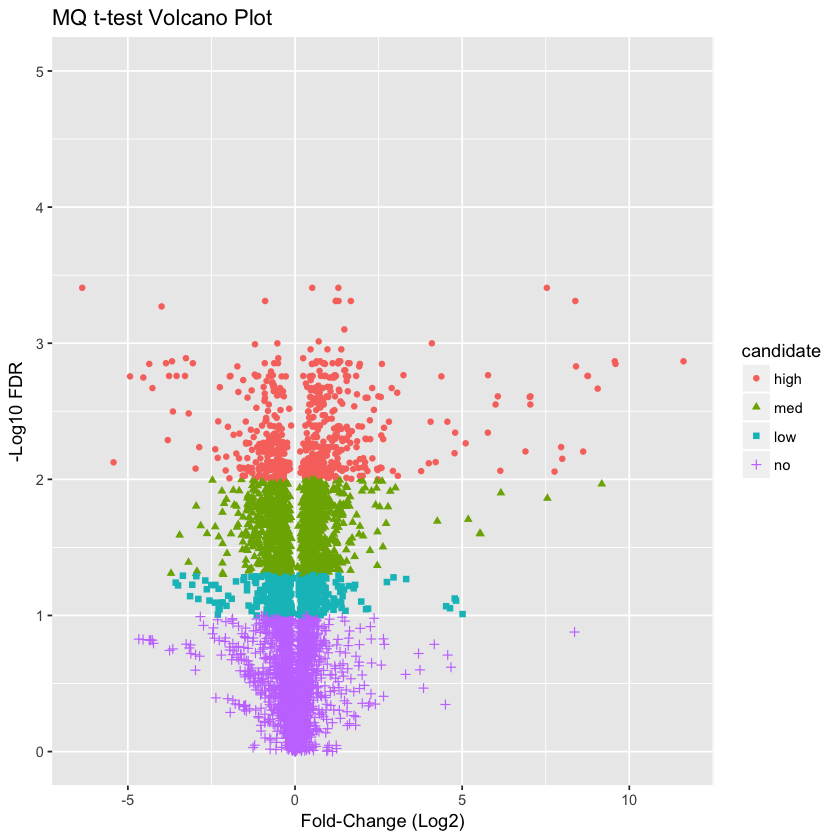

In [122]:
volcano_tt <- data.frame(log2(ttest_MQ$ave_exo / ttest_MQ$ave_media), log10(ttest_MQ$fdr)*(-1), ttest_MQ$candidate)
colnames(volcano_tt) <- c("FoldChange", "FDR", "candidate")

# make a volcano plot
ggplot(volcano_tt, aes(x = FoldChange, y = FDR)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  xlab("Fold-Change (Log2)") +
  ylab("-Log10 FDR") +
  ylim(c(NA, 5)) +
  ggtitle("MQ t-test Volcano Plot")

Warning message:
“Removed 519 rows containing missing values (geom_point).”

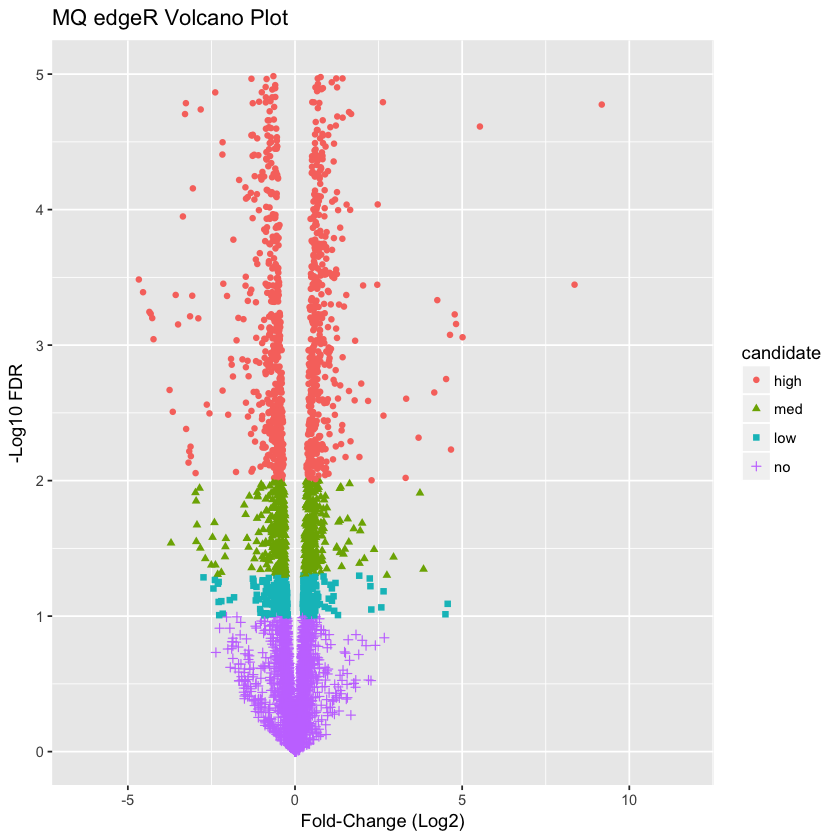

In [123]:
# replot the edgeR volcano plot on same y-scale for comparison
ggplot(volcano_MQ, aes(x = FoldChange, y = FDR)) +
  geom_point(aes(color = candidate, shape = candidate)) +
  xlab("Fold-Change (Log2)") +
  ylab("-Log10 FDR") +
  ylim(c(NA, 5)) +
  ggtitle("MQ edgeR Volcano Plot")

# Plain t-test is much worse than edgeR!
## Every aspect of the t-test looks pretty bad
* less difference between candidate categories
* many protein with small fold-changes are significant
* less correlation between low p-value and large fold change
* statistically significant candidates are a little biased towards higher intensities
* "ranking" the top candidates for follow up work looks more difficult to do